In [1]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
import pandas as pd
import time
import re, io, nltk, torch 
from nltk.corpus import stopwords
from numpy import linalg as LA
from numpy.linalg import norm
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from tqdm import tqdm, trange
from sklearn.utils.class_weight import compute_class_weight
from gensim import utils, matutils  
from gensim.corpora.dictionary import Dictionary
from six import string_types, integer_types
from six.moves import zip, range
from numpy import linalg as LA
from sklearn.preprocessing import Normalizer
from scipy import stats
from gensim.utils import deprecated
from numpy import dot, float32 as REAL, memmap as np_memmap, \
    double, array, zeros, vstack, sqrt, newaxis, integer, \
    ndarray, sum as np_sum, prod, argmax
from collections import Counter
from scipy.spatial import distance
from numpy.random import binomial
from scipy.stats import bernoulli
import numpy as np

import transformers
from transformers import (
    WEIGHTS_NAME,
    AdamW,
    BertConfig,
    BertForMaskedLM,
    BertForSequenceClassification,
    BertTokenizer,
    CamembertConfig,
    CamembertForMaskedLM,
    CamembertTokenizer,
    DistilBertConfig,
    DistilBertForMaskedLM,
    DistilBertTokenizer,
    GPT2Config,
    GPT2LMHeadModel,
    GPT2Tokenizer,
    OpenAIGPTConfig,
    OpenAIGPTLMHeadModel,
    OpenAIGPTTokenizer,
    RobertaConfig,
    RobertaForMaskedLM,
    RobertaTokenizer,
    get_linear_schedule_with_warmup,
)

n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

if torch.cuda.is_available():     
    device = torch.device("cuda")
    print('There are',torch.cuda.device_count(),'GPU(s) available.')
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt


dict_cl=dict()
dict_cl[0]='support'
dict_cl[1]='denying'
dict_cl[2]='questioning'
dict_cl[3]='commenting'

#sdqc
d_lab=dict()
d_lab["support"]=0
d_lab["denying"]=1
d_lab["questioning"]=2
d_lab["commenting"]=3

train =pd.read_csv("../Fine-Tuning/CSV_Stance/train_semeval_raw.csv")
val=pd.read_csv("../Fine-Tuning/CSV_Stance/dev_semeval_raw.csv")
test=pd.read_csv("../Fine-Tuning/CSV_Stance/test_semeval_raw.csv")


Using TensorFlow backend.
/home/casapanshop/anaconda2/envs/newpy3_tf1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/casapanshop/anaconda2/envs/newpy3_tf1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/casapanshop/anaconda2/envs/newpy3_tf1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16

There are 1 GPU(s) available.
We will use the GPU: GeForce GTX 1060 6GB


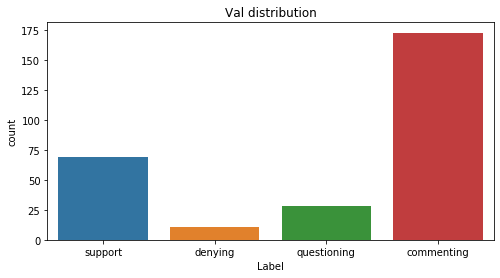

In [2]:
import seaborn as sns
plt.figure(figsize=(8,4))
sns.countplot(val['Label'], order=['support', 'denying', 'questioning', 'commenting'])
plt.title('Val distribution')
plt.show()

In [3]:
def my_normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0: 
        return v
    return v/norm

#el peso max es igual a la clase mas grande
def det_samples(df, dict_class, c_weights=None):
    conteos= Counter(df)
    aumentos= dict()
    maxi= max(conteos.values())
    for clase in conteos:
        if conteos[clase]==maxi:
            class_maxi=clase
            
    if c_weights is None:        # uniform class weights
        for tipo in conteos:
            actual= conteos[tipo]
            if actual<maxi:
                aumentos[tipo]=int(maxi-actual)
            else:
                aumentos[tipo]=0
        return aumentos   
    else:
        try:
            weigths=my_normalize(c_weights)
            max_wei=max(weigths)
            class_max= list(weigths).index(max_wei)
            str_class=dict_class[class_max]
            samples_max=conteos[str_class]
            
            clase=0
            for peso in weigths:
                k=dict_class[clase]
                if peso == max_wei:
                    aumentos[k]= int(samples_max-conteos[k])
                    #print ("aumentos[k]", aumentos[k], 'sampples min', samples_max, 'conteos[clase]', conteos[clase])
                else:
                    futuro=(samples_max/max_wei)*peso
                    aumentos[k]=int(futuro-conteos[k])
                    #print ("aumentos[k] para pesos no minimos ", aumentos[k], "futuro", futuro, "actual", conteos[k])
                clase+=1
            return aumentos
        except:
            print ("No se ha especificado el vector de pesos par balance de datos")
            
            
stoplist = stopwords.words("english")

emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
def my_cleaner(post):      
    s= re.sub(r"http\S+", "html", post)      
    s= re.sub(r'#\w+ ?', "hashtag", s) 
    s= re.sub(r'@\w+ ?', "user", s)
    s= s.lower()    
    s=emoji_pattern.sub(r'', s)
    sl= list(s.split())  
    sl=[word for word in sl if word not in stoplist]
    s=' '.join([word for word in s.split() if word not in stoplist])
    return s, sl

def Sort_Tuple(tup):  
    return(sorted(tup, key = lambda x: x[1]))   
  
def re_generar(muestra, tags_all, tag, prob):
    sent, indices, tags = just_tag_word(muestra, tags_all, tag)
    noise_mask = bernoulli.rvs(prob, size=sent.shape)
    bool_list=list(map(bool,noise_mask))
    to_replace=sent[bool_list]
    indix=indices[bool_list]  
    tagx=tags[bool_list] 
    idx_to_orig=len(sent)
    return  to_replace , indix, tagx, idx_to_orig

puntos='!?."()[´]“<>¡¿-/;:=_”@#.'

def just_tag_word(sentence, tags_all, tag):
    n_sentence=[]
    indices=[]
    valid=[]
    i=0
    for wd in sentence:
        if wd in puntos or wd[0]=='#':
            i+=1
            continue
        else:
            if tags_all[i] not in tag:
                i+=1
                continue
            else:
                n_sentence.append(wd)
                indices.append(i)
                valid.append(tags_all[i])
            i+=1
    return np.asarray(n_sentence), np.asarray(indices), np.asarray(valid)

def all_tag_word(sentence):    
    n_sentence=[]
    for wd in sentence:
        if wd in puntos or wd[0]=='#':
            continue
        else:
            n_sentence.append(wd)    
    return np.asarray(n_sentence), np.asarray(indices), np.asarray(valid)
    
def all_tag_word2(sentence):
    n_sentence=[]
    for wd in sentence:
        if ('unused' in token) or token.isdigit() or token[:-2].isdigit() or token in puntos or "##" in token or len(token) < 2: 
            continue
        else:
            n_sentence.append(wd)
    return np.asarray(n_sentence)
        
    

def check_word(token, tag, clase):
    if ('unused' in token) or token.isdigit() or token[:-2].isdigit() or token in puntos or "##" in token or len(token) < 2: 
        return False
    else:
        if nltk.pos_tag([token])[0][-1]==tag and token in vocabulary[clase]:
            return True
        else: 
            return False

def check_vocab(token, clase):
    if ('unused' in token) or token.isdigit() or token[:-2].isdigit() or  token in puntos or "##" in token or len(token) < 2: 
        return False
    else:
        if token in vocabulary[clase]:
            return True
        else: 
            return False
        
def check_tag(token, tag):
    if ('unused' in token) or token.isdigit() or token[:-2].isdigit() or token in puntos or "##" in token or len(token) < 2: 
        return False
    else:
        if nltk.pos_tag([token])[0][-1]==tag:
            return True
        else: 
            return False
        
def check_vocab(token, clase):
    if ('unused' in token) or token.isdigit() or token[:-2].isdigit() or token in puntos or "##" in token or len(token) < 2: 
        return False
    else:
        if token in vocabulary[clase]:
            return True
        else: 
            return False
            
def check_valid(lista, tags):
    keep=[]
    lista_tag= [nltk.pos_tag([wd])[0][-1] for wd in lista] 
    #print ("Tags de pos/neg:", lista_tag)
    for tag, word in list(zip(lista_tag , lista)):
        if tag in tags:
            keep.append(word)
    return keep
            
def my_most_similar_cosmul(space, M_BERT_space, bias, positive=None, negative=None, topn=1 ): #agregar space de vpcab
    if isinstance(topn, int) and topn < 1:
        return []
    if positive is None:
        positive = []
    if negative is None:
        negative = []
    if isinstance(positive, str) and not negative:
        positive = [positive]
  
    ids_pos = [
        Word2Index[word] if isinstance(word, string_types) else 'Tipo positivo no admitido'
        for word in positive
    ]
    
    positive = [M_BERT_space[idx] for idx in ids_pos]  #space de vocab
    ids_nega= [
        Word2Index[word] if isinstance(word, string_types) else 'Tipo negativo no admitido'
        for word in negative
    ]
    negative = [M_BERT_space[idx] for idx in ids_nega] #space de vocab

    if not positive:
        raise ValueError("cannot compute similarity with no input")
    
    
    pos_dists = [((1 + dot(space, term))/2) for term in positive]
    
    pos_dists[0]=pos_dists[0] + bias
    neg_dists = [((1 + dot(space, term))/2) for term in negative]
    dists = prod(pos_dists, axis=0) / (prod(neg_dists, axis=0) + 0.000001)
    
    if not topn:
        return dists
    best = matutils.argsort(dists, topn=topn + len(positive + negative), reverse=True)  #ordena en vocab used


    return best, dists[best] #retorna indices y distancias asociadas


def find_positive(lista, target, id_target, bias, window=4):
    to_return=[target]
    to_return=to_return*int(bias)
    positive_temp=find_window(lista, target, id_target, window=window)
    to_return+=positive_temp
    
    return to_return
                  

def find_window(lista, target, id_target, window=4):  #wind debe ser par   
    to_return=[]
    sub_w=int(window/2)
    
    if id_target >= sub_w and id_target + sub_w < len(lista):
        atras=lista[id_target-sub_w:id_target]
        adelante=lista[id_target+1:id_target+1+sub_w]
        
    elif id_target  < sub_w:
        atras=lista[:id_target]
        adelante=lista[id_target+1:id_target+sub_w+1]
        
    elif id_target + sub_w >= len(lista): 
        atras=lista[id_target-sub_w:id_target]
        adelante= lista[id_target+1:]
        
    to_return+=atras
    to_return+=adelante
    return to_return


def find_negative(target, not_sent, window=4):
    cleaned = tokenizer_loaded.tokenize(my_cleaner(not_sent)[0])
    ide = cleaned.index(target)
    wind_neg=find_window(list(cleaned), target, ide, window=window)
   
    return wind_neg


def sample_neg_class(cl):
    if type(cl) != list:
        cl = [cl]
    aux = list(d_lab.keys())
    for value in cl:
        aux.remove(value)
    samp_neg = np.random.choice(aux)
    
    used_classes = cl
    used_classes.append(samp_neg)
    return samp_neg, used_classes

def check_special(lista):
    exceptions=['[CLS]', '[SEP]', '[MASK]']
    to_return=[]
    for item in lista:  #es una tupla
        if item[0] not in exceptions: 
            to_return.append(item[0])
        else:
            continue
    return to_return

def choose_replace(candidatos, ide, target):
    candidatos=check_special(candidatos)
    try:
        candidatos.remove(target)
    except:
        pass
    
    elem=np.random.choice(candidatos)
    return (elem, ide)
        

def aumentar_clase(clase, num_ejem, tags_all, prob, TOPN):
    dict_resumen=dict()
    new_sample=[]
    indx=train['Label']==clase
    print ("Consultando por la clase", clase)
    label=d_lab[clase]    
    print ("Entrega label", label)
    contador=1
    
    no_modificados=0
    modificados=0
    terms_modif=0  
    terms_supuestos=0  
    totales=0
    largos=0
    SENT_LEN=0
    TOPE_LEN=0
    
    if num_ejem>0:
        while (len(new_sample)<num_ejem):
            muestras=train['Tweet'][indx]
            tw_ids=train['Tw_id'][indx]
            for muestra in muestras:  
                if len(new_sample)<num_ejem:
                    pre=np.asarray(tokenizer_loaded.tokenize(my_cleaner(muestra)[0]))                    
                    tags_pre= [nltk.pos_tag([wd])[0][-1] for wd in pre]
                    terms, indxs, tagx, tope_replace= re_generar(pre, tags_pre, tags_all, prob)  #terms to replace
                    terms_supuestos+=len(terms)

                    news=[]
                    TOPE_LEN+=tope_replace
                    SENT_LEN+=len(terms)
                    
                    if len(terms)>0:     
                        
                        for term, ind, tag in list(zip(terms, indxs, tagx)):                           
                            mask_words = np.asarray(d_vocab[clase]) & np.asarray(d_pos[tag])
                            vocab_used_pos = np.arange(len(mask_words))[mask_words]
                            space= M_BERT_space[mask_words] #vocab de clase y tag
                            
                            if term!='user' and term!='hashtag' and term!='html':
                                not_clase, used_classes = sample_neg_class(clase) #definir clases a buscar
                                
                                valid_pos=[]
                                pos = find_positive(list(pre), term, ind, bias=1, window=4) #se puede cambiar la ventana! 
                                valid_pos=check_valid(pos, tags_all)

                                id_need = 999999999 #simbolo de que no encontró tweet
                                neg = []
                                while(id_need == 999999999):
                                    try:
                                        id_need = np.random.choice(dic_IdxI[not_clase][term]) #sample id
                                    except:
                                        if len(used_classes) == len(d_lab.keys()): 
                                            break #ya revisó todas las clases
                                        not_clase, used_classes = sample_neg_class(used_classes) # change class 

                                valid_neg=[]
                                if id_need != 999999999: #si encontró tweet
                                    not_sent = train["Tweet"][id_need]
                                    neg = find_negative(term, not_sent, window=4)  
                                    valid_neg=check_valid(neg, tags_all)

                                if len(valid_neg)<1 or len(valid_pos)<1:
                                    continue
                                    #pass

                                best, dists_best = my_most_similar_cosmul(space, M_BERT_space, 0.0, positive=valid_pos, negative=valid_neg, topn=TOPN)
                                

                                todo_words = {
                                    Word2Index[word] for word in valid_pos + valid_neg
                                    if not isinstance(word, ndarray) and word in Word2Index
                                    }
                                result = []
                                for sim, dist_sim in list(zip(best, dists_best)):
                                    n_sim = vocab_used_pos[sim]
                                    if n_sim not in todo_words:
                                        result.append((idx_2_token[n_sim], float(dist_sim)))
                                        
                                if len(result)>0:
                                    candidatos = result[:TOPN] #+2
                                else:
                                    continue

                                new = choose_replace(candidatos, ind, term)  
                                news.append(new) 
                                if tag in dict_resumen.keys():
                                    dict_resumen[tag]+=1
                                else:
                                    dict_resumen[tag]=1
                                
                        cambia=False
                        news= Sort_Tuple(news) 
                        
                        if len(news)<1:
                            no_modificados+=1
                            continue
                        else:
                            x=np.asarray(news)[:,1]
                            y=np.asarray(news)[:,0]
                            n_news=np.asarray(np.vstack((x,y))).T

                            nueva_sent=[]
                            cont_new=0
                            for i in range(len(pre)):
                                try:
                                    if int(n_news[cont_new][0])==i:
                                        nueva_sent.append(n_news[cont_new][1])                 
                                        cont_new+=1
                                    else: 
                                        nueva_sent.append(pre[i])
                                except: 
                                    nueva_sent.append(pre[i])
                       
                            totales+=cont_new

                            """
                            print ("Sentencia original:")
                            print (pre)
                            print ("Sentencia final:" , label)
                            print (nueva_sent)
                            print ("")
                            print ("")
                            """
                            new_sample.append([contador, nueva_sent, label])
                            modificados+=1
                            terms_modif+=len(news)
                            largos+=len(pre)
                            contador+=1
                               

                else:
                    count= Counter(train['Label'])   
                    for muestra, twid in list(zip(muestras,tw_ids)) :
                        pre=np.asarray(tokenizer_loaded.tokenize(my_cleaner(muestra)[0]))
                        new_sample.append([twid, pre, label])
                    break
                    
    else:
        count= Counter(train['Label'])
        news= train[indx].sample(count[clase]+num_ejem)
        news_tw=news['Tweet'].values
        news_id=news['Tw_id'].values
        for muestra, twid in list(zip(news_tw, news_id)):
            pre=np.asarray(tokenizer_loaded.tokenize(my_cleaner(muestra)[0]))
            new_sample.append([twid, pre, label])

    try:
        print ("# terms modificados promedio", terms_modif/modificados ,"términos por sentencia")
        print ("Largo de sentencia promedio", largos/modificados ,"términos por sentencia")
        print ("para esta ejecución se debiesen reemplazar", SENT_LEN, " de" ,TOPE_LEN, "terminos")

    except: 
        print ("No se generan ejemplos")

    return new_sample, dict_resumen


def predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, name_model):
    etiq = etiq.astype("int")
    trainPredict = trained.predict(x_train, batch_size=32)
    trainPredict=[np.argmax(pred) for pred in trainPredict]
    acc= accuracy_score(etiq, trainPredict)  
    f1=f1_score(etiq, trainPredict, average=None)  # labels=np.unique(trainPredict)
    f1_ma=f1_score(etiq, trainPredict, average='macro')  # labels=np.unique(trainPredict)
    print ("")
    print ("Accuracy sobre Train", name_model, ":",acc)  
    print ("F1-score None sobre Train", name_model, ":",f1)
    print ("F1-score macro sobre Train", name_model, ":",f1_ma)
    ########################################
    trainPredict = trained.predict(x_val, batch_size=32)
    trainPredict=[np.argmax(pred) for pred in trainPredict]
    acc= accuracy_score(etiq_v, trainPredict)  
    f1=f1_score(etiq_v, trainPredict, average=None)  # labels=np.unique(trainPredict)
    f1_ma=f1_score(etiq_v, trainPredict, average='macro')  # labels=np.unique(trainPredict)
    print ("")
    print ("Accuracy sobre Val", name_model, ":",acc)  
    print ("F1-score None sobre Val", name_model, ":",f1)
    print ("F1-score macro sobre Val", name_model, ":",f1_ma)
    ########################################
    trainPredict = trained.predict(x_test, batch_size=32)
    trainPredict=[np.argmax(pred) for pred in trainPredict]
    acc_t= accuracy_score(etiq_t, trainPredict)  
    f1_t=f1_score(etiq_t, trainPredict, average=None)  # labels=np.unique(trainPredict)
    f1_ma_t=f1_score(etiq_t, trainPredict, average='macro')  # labels=np.unique(trainPredict)
    matriz_t=normalize(confusion_matrix(etiq_t, trainPredict))
    print ("")
    print ("Accuracy sobre Test", name_model, ":",acc_t)  
    print ("F1-score None sobre Test", name_model, ":",f1_t)
    print ("F1-score macro sobre Test", name_model, ":",f1_ma_t)
    
    return f1_ma_t, f1_t, acc_t, matriz_t

In [4]:
dir_path='../../model_save/Dos-Fases-all_Stance/'
tokenizer_loaded = BertTokenizer.from_pretrained(dir_path)#'bert-base-uncased')
model_loaded = BertForSequenceClassification.from_pretrained(dir_path, num_labels=4)#'bert-base-uncased',  num_labels=4) 
idx_2_token = tokenizer_loaded.ids_to_tokens
archivo = open(dir_path+'vocab.txt','r')
Word2Index={word.strip():i for i,word in enumerate(archivo.readlines())}
M_BERT_space = model_loaded.bert.embeddings.word_embeddings.weight.detach().cpu().numpy()
transformer = Normalizer().fit(M_BERT_space) 
M_BERT_space=transformer.transform(M_BERT_space)


#indice invertido para cada clase
tr_s=train.loc[train['Label']=='support']
tr_d=train.loc[train['Label']=='denying']
tr_q=train.loc[train['Label']=='questioning']
tr_c=train.loc[train['Label']=='commenting']

keys=['support', 'denying', 'questioning', 'commenting']

dict_clases={}
for key in keys: 
    tr_k=train.loc[train['Label']==key]
    tr_k=tr_k['Tweet'].values    
    trs_k=[]
    for tw in tr_k:
        encoded_sent = tokenizer_loaded.tokenize(my_cleaner(tw)[0])
        trs_k.append(encoded_sent)
    dict_clases[key]=trs_k  

dict_vocab={}
for key in keys: 
    lista=dict_clases[key]
    new_list=[]
    for tw in lista:
        new_list=new_list+tw
    print ("#terms ",key,":",len(new_list))
    dict_vocab[key]=new_list
      
vocabulary={}
for key in keys: 
    temp=list(set(dict_vocab[key]))
    print ("#Tweets",key,":",len(temp))
    vocabulary[key]=temp
    

dic_IdxI = {value: {} for value in d_lab.keys()}
for i, (muestra, label) in enumerate(list(zip(train['Tweet'],train['Label']))):
    pre=np.asarray(tokenizer_loaded.tokenize(my_cleaner(muestra)[0]))
    for token in pre:
        if token not in dic_IdxI[label]:
            dic_IdxI[label][token] = [i]
        else:
            dic_IdxI[label][token].append(i)
            
tags=['NN','NNS', 'JJ', 'JJR', 'JJS', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']
clases=['support', 'denying', 'questioning', 'commenting']
MAX_LEN = 50

d_pos= dict()
for tag in tags:
    d_pos[tag]= [check_tag(k, tag) for k in idx_2_token.values()]
    
d_vocab=dict()
for clase in clases:
    d_vocab[clase]= [check_vocab(k, clase) for k in idx_2_token.values()]
    

#terms  support : 13504
#terms  denying : 4874
#terms  questioning : 4026
#terms  commenting : 37926
#Tweets support : 2442
#Tweets denying : 1628
#Tweets questioning : 1345
#Tweets commenting : 5270


In [5]:
len(set(dict_vocab['denying']))

1628

#### POS tags 

- JJ adjective 'big'
- JJR adjective, comparative 'bigger'
- JJS adjective, superlative 'biggest'

- NN noun, singular 'desk'
- NNS noun plural 'desks'
- NNP proper noun, singular 'Harrison'
- NNPS proper noun, plural 'Americans'

- RB adverb very, silently,   (no considerado) 
- RBR adverb, comparative better  (no considerado)
- RBS adverb, superlative best  (no considerado)

- VB verb, base form take    
- VBD verb, past tense took
- VBG verb, gerund/present participle taking
- VBN verb, past participle taken
- VBP verb, sing. present, non-3d take
- VBZ verb, 3rd person sing. present takes



## Generación Varias

In [6]:
from models import *

In [7]:
etiq_v=[]
for et in val['Label'].values:
    etiq_v.append(d_lab[et])
n_labels_val = np.array(etiq_v)
y_val=to_categorical(n_labels_val,num_classes=4)
sentences_val = val['Tweet'].values
input_ids_val = []
for sent in sentences_val:
    encoded_sent = tokenizer_loaded.encode(my_cleaner(sent)[0],add_special_tokens = False)    
    input_ids_val.append(encoded_sent)
input_ids_val = pad_sequences(input_ids_val, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")

etiq_t=[]
for et in test['Label'].values:
    etiq_t.append(d_lab[et])
n_labels_test = np.array(etiq_t)
y_test=to_categorical(n_labels_test,num_classes=4)
sentences_test = test['Tweet'].values
input_ids_test = []
for sent in sentences_test:
    encoded_sent = tokenizer_loaded.encode(my_cleaner(sent)[0],add_special_tokens = False)    
    input_ids_test.append(encoded_sent)
input_ids_test = pad_sequences(input_ids_test, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")


In [8]:
shape_val=np.asarray(input_ids_val).shape
x_val=np.zeros((shape_val[0], shape_val[1], 768))
i=0
for in_id in input_ids_val:
    x_val[i]=M_BERT_space[in_id]
    i+=1
    
shape_test=np.asarray(input_ids_test).shape
x_test=np.zeros((shape_test[0], shape_test[1], 768))
i=0
for in_id in input_ids_test:
    x_test[i]=M_BERT_space[in_id]
    i+=1

x_test.shape


(1021, 50, 768)

#SMOTE
shape_val=np.asarray(input_ids_val).shape
x_val=np.zeros((shape_val[0], 768))
i=0
for in_id in input_ids_val:
    vector=np.zeros(768)
    n = np.sum(in_id != 0)
    for idv in in_id:
        if idv!=0:
            vector+=M_BERT_space[idv]
    x_val[i]=(vector/n)
    i+=1  

shape_test=np.asarray(input_ids_test).shape
x_test=np.zeros((shape_test[0], 768))
i=0
for in_id in input_ids_test:
    vector=np.zeros(768)
    n = np.sum(in_id != 0)
    for idv in in_id:
        if idv!=0:
            vector+=M_BERT_space[idv]
    x_test[i]=(vector/n)
    i+=1  


In [9]:
np.sum(y_val[:,2])

28.0

In [10]:
np.sum(val['Label']=='questioning')

28

### Bias de agregar varias veces a lo mendoza 0.15

In [10]:
prob= 0.15
TOPN = 1

fs_macro={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
fs_none={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
accs={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
confusions={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}

aum_weight=det_samples(train['Label'], dict_cl)

for i in range(5): 
    macro_augmented=[]
    print ("--------------------------------------------------------")
    print ("\nGenerando ejemplos en base a probabilidad --> ", prob)
    print ("--------------------------------------------------------")
    for clase in aum_weight:
        start_time=time.time()
        print ("\nGenerando", aum_weight[clase], "nuevos ejemplos para la clase", clase)
        muestras, dict_aumentos=aumentar_clase(clase, aum_weight[clase], tags, prob, TOPN)
        macro_augmented+=muestras
        print ("Resumen de modificaciones:", dict_aumentos)
        elapsed_time= time.time() - start_time
        print ("Este proceso tomó", elapsed_time, "seg")   

    macro_augmented = np.asarray(macro_augmented, dtype=object)
    np.random.shuffle(macro_augmented)
    
    np.save('../Data_augmented/Stance_agregado/Aumento_'+str(i+1)+'-run_'+str(prob)+'_balanced_w4_app1_Top'+str(TOPN)+'.npy', macro_augmented)
    
    
    ids_train=macro_augmented[:,0]
    tws_train=macro_augmented[:,1]
    labels_train=macro_augmented[:,2]
    class_weights= compute_class_weight('balanced', np.unique(labels_train), labels_train)
    print ("Pesos de clases:", class_weights)
    
    etiq=labels_train.copy()
    sentences = tws_train
    n_labels = np.array(etiq)

    input_ids = []
    for sent in sentences:
        encoded_sent = tokenizer_loaded.encode(list(sent),add_special_tokens = False)    
        input_ids.append(encoded_sent)
    input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                              value=0, truncating="post", padding="post")
    y_train=to_categorical(n_labels,num_classes=4)
    shape=np.asarray(input_ids).shape
    x_train=np.zeros((shape[0], shape[1], 768))
    j=0
    for in_id in input_ids:
        x_train[j]=M_BERT_space[in_id]
        j+=1

    ###########################################################
    ############################################################
    ############################################################
    
    cnn1=create_ccn1(x_train.shape[1:])
    trained =train_model(cnn1, x_train, y_train, x_val, y_val, class_weights, e=30, BS=32, verb=0, focal=True)
    trained.save('exec_baselines/0.15/cnn1_'+str(i+1)+'-exec_w4_app1_Top_'+str(prob)+'_'+str(TOPN)+'.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'cnn1')
    fs_macro['cnn1'].append(f1_ma_t)
    fs_none['cnn1'].append(f1_t)
    accs['cnn1'].append(acc_t)
    confusions['cnn1'].append(matriz_t)
    
    cnn2=create_cnn2(x_train.shape[1:])
    trained =train_model(cnn2, x_train, y_train, x_val, y_val, class_weights, e=30, BS=32, verb=0, focal=True)
    trained.save('exec_baselines/0.15/cnn2_'+str(i+1)+'-exec_w4_app1_Top_'+str(prob)+'_'+str(TOPN)+'.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'cnn2')
    fs_macro['cnn2'].append(f1_ma_t)
    fs_none['cnn2'].append(f1_t)
    accs['cnn2'].append(acc_t)
    confusions['cnn2'].append(matriz_t)
    
    rnn1=create_complex_GRU_2(128,64,"adam",x_train.shape[1:])
    trained =train_model(rnn1, x_train, y_train, x_val, y_val, class_weights, e=30, BS=32, verb=0, focal=True)
    trained.save('exec_baselines/0.15/rnn1_'+str(i+1)+'-exec_w4_app1_Top_'+str(prob)+'_'+str(TOPN)+'.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'rnn1')
    fs_macro['rnn1'].append(f1_ma_t)
    fs_none['rnn1'].append(f1_t)
    accs['rnn1'].append(acc_t)
    confusions['rnn1'].append(matriz_t)
    
    rnn2=create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])
    trained =train_model(rnn2, x_train, y_train, x_val, y_val, class_weights, e=30, BS=32, verb=0, focal=True)
    trained.save('exec_baselines/0.15/rnn2_'+str(i+1)+'-exec_w4_app1_Top_'+str(prob)+'_'+str(TOPN)+'.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'rnn2')
    fs_macro['rnn2'].append(f1_ma_t)
    fs_none['rnn2'].append(f1_t)
    accs['rnn2'].append(acc_t)
    confusions['rnn2'].append(matriz_t)
    
    rnn3=create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])
    trained =train_model(rnn3, x_train, y_train, x_val, y_val, class_weights, e=30, BS=32, verb=0, focal=False)
    trained.save('exec_baselines/0.15/rnn3_'+str(i+1)+'-exec_w4_app1_Top_'+str(prob)+'_'+str(TOPN)+'.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'rnn3')
    fs_macro['rnn3'].append(f1_ma_t)
    fs_none['rnn3'].append(f1_t)
    accs['rnn3'].append(acc_t)
    confusions['rnn3'].append(matriz_t)


--------------------------------------------------------

Generando ejemplos en base a probabilidad -->  0.15
--------------------------------------------------------

Generando 2404 nuevos ejemplos para la clase questioning
# terms modificados promedio 1.4841930116472546 términos por sentencia
Largo de sentencia promedio 14.497088186356073 términos por sentencia
para esta ejecución se debiesen reemplazar 4739  de 31462 terminos
Resumen de modificaciones: {'NN': 2314, 'JJS': 5, 'NNS': 451, 'VBG': 185, 'VBD': 48, 'JJ': 263, 'VBN': 128, 'VB': 143, 'JJR': 12, 'VBZ': 19}
Este proceso tomó 23.648268699645996 seg

Generando 0 nuevos ejemplos para la clase commenting
No se generan ejemplos
Resumen de modificaciones: {}
Este proceso tomó 0.7654829025268555 seg

Generando 1893 nuevos ejemplos para la clase support
# terms modificados promedio 1.7152667723190702 términos por sentencia
Largo de sentencia promedio 18.183306920232436 términos por sentencia
para esta ejecución se debiesen reemplazar

 - val_f1: 0.000000 
 - val_f1: 0.154676 
 - val_f1: 0.211693 
 - val_f1: 0.265769 
 - val_f1: 0.219782 
 - val_f1: 0.257667 
 - val_f1: 0.296452 
 - val_f1: 0.213596 
 - val_f1: 0.360375 
 - val_f1: 0.289391 
 - val_f1: 0.439360 
 - val_f1: 0.424677 
 - val_f1: 0.438681 
 - val_f1: 0.348046 
 - val_f1: 0.421965 
 - val_f1: 0.319538 
 - val_f1: 0.383207 
 - val_f1: 0.338558 
 - val_f1: 0.292524 
 - val_f1: 0.445724 
 - val_f1: 0.424703 
 - val_f1: 0.411310 
 - val_f1: 0.403773 
 - val_f1: 0.464731 
 - val_f1: 0.456169 
 - val_f1: 0.462776 
 - val_f1: 0.426921 
 - val_f1: 0.406154 
 - val_f1: 0.438105 
 - val_f1: 0.467000 

Accuracy sobre Train rnn2 : 0.8942026335040234
F1-score None sobre Train rnn2 : [0.76093361 0.98641703 0.98467087 0.82987937]
F1-score macro sobre Train rnn2 : 0.8904752206750071

Accuracy sobre Val rnn2 : 0.6548042704626335
F1-score None sobre Val rnn2 : [0.5        0.14814815 0.50746269 0.76373626]
F1-score macro sobre Val rnn2 : 0.4798367746128941

Accuracy sobre 


Accuracy sobre Test rnn2 : 0.6650342801175319
F1-score None sobre Test rnn2 : [0.1        0.11009174 0.4495114  0.79415671]
F1-score macro sobre Test rnn2 : 0.363439962569509
 - val_f1: 0.213154 
 - val_f1: 0.275178 
 - val_f1: 0.298280 
 - val_f1: 0.340846 
 - val_f1: 0.442032 
 - val_f1: 0.547290 
 - val_f1: 0.421112 
 - val_f1: 0.489011 
 - val_f1: 0.486918 
 - val_f1: 0.462508 
 - val_f1: 0.365856 
 - val_f1: 0.477223 
 - val_f1: 0.475127 
 - val_f1: 0.437218 
 - val_f1: 0.446835 
 - val_f1: 0.456110 
 - val_f1: 0.454701 
 - val_f1: 0.463768 
 - val_f1: 0.388276 
 - val_f1: 0.394951 
 - val_f1: 0.474770 
 - val_f1: 0.454064 
 - val_f1: 0.416291 
 - val_f1: 0.440894 
 - val_f1: 0.434161 
 - val_f1: 0.461867 
 - val_f1: 0.428411 
 - val_f1: 0.423477 
 - val_f1: 0.457857 
 - val_f1: 0.316799 

Accuracy sobre Train rnn3 : 0.8211411850768106
F1-score None sobre Train rnn3 : [0.73971861 0.9902877  0.91668316 0.6186398 ]
F1-score macro sobre Train rnn3 : 0.8163323188983911

Accuracy sobr

 - val_f1: 0.402219 
 - val_f1: 0.400149 
 - val_f1: 0.493096 
 - val_f1: 0.397834 
 - val_f1: 0.452648 

Accuracy sobre Train rnn3 : 0.9863752743233358
F1-score None sobre Train rnn3 : [0.9790991  0.99411548 0.99321474 0.97919352]
F1-score macro sobre Train rnn3 : 0.9864057113998281

Accuracy sobre Val rnn3 : 0.6192170818505338
F1-score None sobre Val rnn3 : [0.5380117  0.         0.59090909 0.7120743 ]
F1-score macro sobre Val rnn3 : 0.4602487725552741

Accuracy sobre Test rnn3 : 0.6033300685602351
F1-score None sobre Test rnn3 : [0.09027778 0.12844037 0.38410596 0.75903614]
F1-score macro sobre Test rnn3 : 0.34046506239836716
--------------------------------------------------------

Generando ejemplos en base a probabilidad -->  0.15
--------------------------------------------------------

Generando 2404 nuevos ejemplos para la clase questioning
# terms modificados promedio 1.471297836938436 términos por sentencia
Largo de sentencia promedio 14.389351081530782 términos por sentenci

# terms modificados promedio 1.483361064891847 términos por sentencia
Largo de sentencia promedio 14.471297836938437 términos por sentencia
para esta ejecución se debiesen reemplazar 4721  de 31475 terminos
Resumen de modificaciones: {'NN': 2293, 'VB': 146, 'NNS': 472, 'JJ': 252, 'VBG': 170, 'VBZ': 26, 'VBN': 146, 'JJR': 3, 'VBD': 53, 'JJS': 5}
Este proceso tomó 24.294464111328125 seg

Generando 0 nuevos ejemplos para la clase commenting
No se generan ejemplos
Resumen de modificaciones: {}
Este proceso tomó 0.7723925113677979 seg

Generando 1893 nuevos ejemplos para la clase support
# terms modificados promedio 1.6962493396724776 términos por sentencia
Largo de sentencia promedio 18.221870047543582 términos por sentencia
para esta ejecución se debiesen reemplazar 4053  de 27183 terminos
Resumen de modificaciones: {'JJ': 222, 'NN': 2167, 'NNS': 364, 'VBG': 182, 'VBD': 38, 'VBN': 111, 'VB': 75, 'JJS': 23, 'JJR': 3, 'VBZ': 25, 'VBP': 1}
Este proceso tomó 21.694880962371826 seg

Generando 

In [11]:
for key in fs_none.keys():
    temp=np.zeros(4)
    for result in fs_none[key]:
        temp+=result
    print ("(0.15) app1 F1-score promedio para",key,":" ,temp/5)

print ("")
for key in fs_macro.keys():
    temp=np.sum(fs_macro[key])
    print ("(0.15) app1 F1-score macro promedio para",key,":" ,temp/5, "desvest: ",np.std(fs_macro[key]))

print ("")
for key in accs.keys():
    temp=np.sum(accs[key])
    print ("(0.15) app1 Accuracy promedio para",key,":" ,temp/5)

(0.15) app1 F1-score promedio para cnn1 : [0.05913829 0.09808888 0.5217745  0.83704027]
(0.15) app1 F1-score promedio para cnn2 : [0.05451985 0.13171355 0.48291867 0.83916968]
(0.15) app1 F1-score promedio para rnn1 : [0.10359302 0.15578247 0.44426169 0.7402233 ]
(0.15) app1 F1-score promedio para rnn2 : [0.07054107 0.125021   0.35862213 0.78863088]
(0.15) app1 F1-score promedio para rnn3 : [0.09520153 0.13992543 0.40179281 0.58644398]

(0.15) app1 F1-score macro promedio para cnn1 : 0.3790104855493358 desvest:  0.02361467036822488
(0.15) app1 F1-score macro promedio para cnn2 : 0.37708043815958014 desvest:  0.026367322793435764
(0.15) app1 F1-score macro promedio para rnn1 : 0.36096511926969593 desvest:  0.02432136330304215
(0.15) app1 F1-score macro promedio para rnn2 : 0.33570377110678357 desvest:  0.028796318032862478
(0.15) app1 F1-score macro promedio para rnn3 : 0.305840934771976 desvest:  0.05909817209921237

(0.15) app1 Accuracy promedio para cnn1 : 0.7263467189030363
(0.15) a

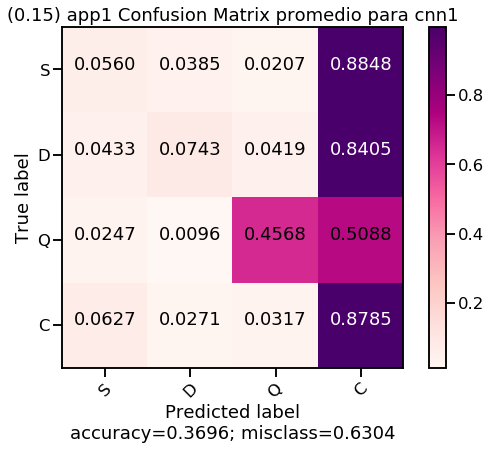

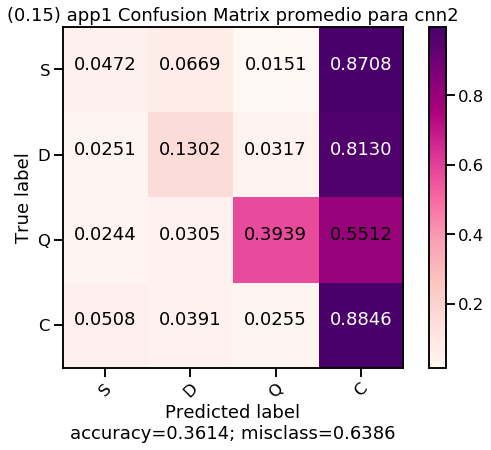

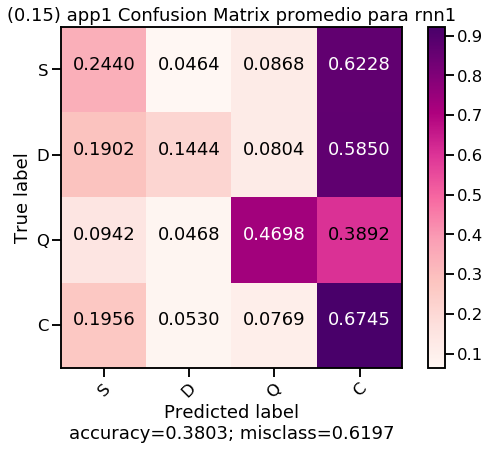

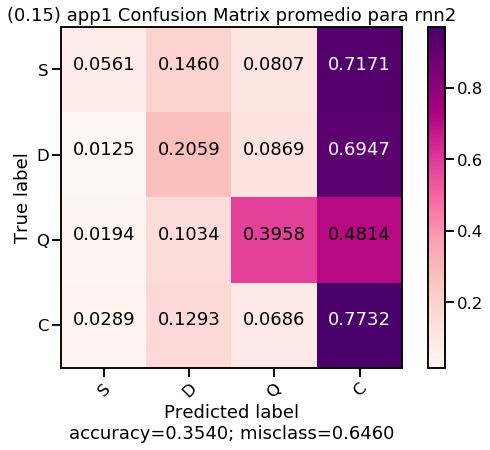

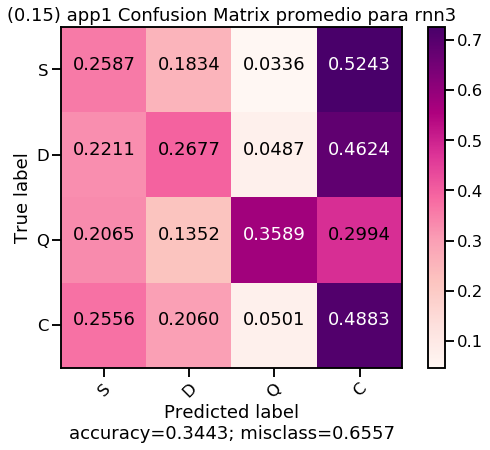

In [13]:
for key in confusions.keys():
    temp=np.sum(confusions[key], axis=0)/5.0
    plot_confusion_matrix(temp, ['S','D','Q','C'], "(0.15) app1 Confusion Matrix promedio para "+str(key), cmap='RdPu')

### Masking 0.85

In [14]:
prob= 0.85
TOPN = 1

fs_macro={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
fs_none={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
accs={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
confusions={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}

aum_weight=det_samples(train['Label'], dict_cl)

for i in range(5): 
    macro_augmented=[]
    print ("--------------------------------------------------------")
    print ("\nGenerando ejemplos en base a probabilidad --> ", prob)
    print ("--------------------------------------------------------")
    for clase in aum_weight:
        start_time=time.time()
        print ("\nGenerando", aum_weight[clase], "nuevos ejemplos para la clase", clase)
        muestras, dict_aumentos=aumentar_clase(clase, aum_weight[clase], tags, prob, TOPN)
        macro_augmented+=muestras
        print ("Resumen de modificaciones:", dict_aumentos)
        elapsed_time= time.time() - start_time
        print ("Este proceso tomó", elapsed_time, "seg")   

    macro_augmented = np.asarray(macro_augmented, dtype=object)
    np.random.shuffle(macro_augmented)
    
    np.save('../Data_augmented/Stance_agregado/Aumento_'+str(i+1)+'-run_'+str(prob)+'_balanced_w4_app1_Top'+str(TOPN)+'.npy', macro_augmented)
    
    ids_train=macro_augmented[:,0]
    tws_train=macro_augmented[:,1]
    labels_train=macro_augmented[:,2]
    class_weights= compute_class_weight('balanced', np.unique(labels_train), labels_train)
    print ("Pesos de clases:", class_weights)
    
    etiq=labels_train.copy()
    sentences = tws_train
    n_labels = np.array(etiq)

    input_ids = []
    for sent in sentences:
        encoded_sent = tokenizer_loaded.encode(list(sent),add_special_tokens = False)    
        input_ids.append(encoded_sent)
    input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                              value=0, truncating="post", padding="post")
    y_train=to_categorical(n_labels,num_classes=4)
    shape=np.asarray(input_ids).shape
    x_train=np.zeros((shape[0], shape[1], 768))
    j=0
    for in_id in input_ids:
        x_train[j]=M_BERT_space[in_id]
        j+=1

    ###########################################################
    ############################################################
    ############################################################
    
    cnn1=create_ccn1(x_train.shape[1:])
    trained =train_model(cnn1, x_train, y_train, x_val, y_val, class_weights, e=30, BS=32, verb=0, focal=True)
    trained.save('exec_baselines/0.85/cnn1_'+str(i+1)+'-exec_w4_app1_Top_'+str(prob)+'_'+str(TOPN)+'.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'cnn1')
    fs_macro['cnn1'].append(f1_ma_t)
    fs_none['cnn1'].append(f1_t)
    accs['cnn1'].append(acc_t)
    confusions['cnn1'].append(matriz_t)
    
    cnn2=create_cnn2(x_train.shape[1:])
    trained =train_model(cnn2, x_train, y_train, x_val, y_val, class_weights, e=30, BS=32, verb=0, focal=True)
    trained.save('exec_baselines/0.85/cnn2_'+str(i+1)+'-exec_w4_app1_Top_'+str(prob)+'_'+str(TOPN)+'.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'cnn2')
    fs_macro['cnn2'].append(f1_ma_t)
    fs_none['cnn2'].append(f1_t)
    accs['cnn2'].append(acc_t)
    confusions['cnn2'].append(matriz_t)
    
    rnn1=create_complex_GRU_2(128,64,"adam",x_train.shape[1:])
    trained =train_model(rnn1, x_train, y_train, x_val, y_val, class_weights, e=30, BS=32, verb=0, focal=True)
    trained.save('exec_baselines/0.85/rnn1_'+str(i+1)+'-exec_w4_app1_Top_'+str(prob)+'_'+str(TOPN)+'.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'rnn1')
    fs_macro['rnn1'].append(f1_ma_t)
    fs_none['rnn1'].append(f1_t)
    accs['rnn1'].append(acc_t)
    confusions['rnn1'].append(matriz_t)
    
    rnn2=create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])
    trained =train_model(rnn2, x_train, y_train, x_val, y_val, class_weights, e=30, BS=32, verb=0, focal=True)
    trained.save('exec_baselines/0.85/rnn2_'+str(i+1)+'-exec_w4_app1_Top_'+str(prob)+'_'+str(TOPN)+'.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'rnn2')
    fs_macro['rnn2'].append(f1_ma_t)
    fs_none['rnn2'].append(f1_t)
    accs['rnn2'].append(acc_t)
    confusions['rnn2'].append(matriz_t)
    
    rnn3=create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])
    trained =train_model(rnn3, x_train, y_train, x_val, y_val, class_weights, e=30, BS=32, verb=0, focal=False)
    trained.save('exec_baselines/0.85/rnn3_'+str(i+1)+'-exec_w4_app1_Top_'+str(prob)+'_'+str(TOPN)+'.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'rnn3')
    fs_macro['rnn3'].append(f1_ma_t)
    fs_none['rnn3'].append(f1_t)
    accs['rnn3'].append(acc_t)
    confusions['rnn3'].append(matriz_t)
    

--------------------------------------------------------

Generando ejemplos en base a probabilidad -->  0.85
--------------------------------------------------------

Generando 2404 nuevos ejemplos para la clase questioning
# terms modificados promedio 4.288685524126456 términos por sentencia
Largo de sentencia promedio 12.843178036605657 términos por sentencia
para esta ejecución se debiesen reemplazar 13673  de 16055 terminos
Resumen de modificaciones: {'NN': 6670, 'VBD': 160, 'JJ': 740, 'NNS': 1290, 'VB': 467, 'JJS': 13, 'VBG': 482, 'VBN': 400, 'VBZ': 68, 'JJR': 20}
Este proceso tomó 49.563156604766846 seg

Generando 0 nuevos ejemplos para la clase commenting
No se generan ejemplos
Resumen de modificaciones: {}
Este proceso tomó 0.8636987209320068 seg

Generando 1893 nuevos ejemplos para la clase support
# terms modificados promedio 6.442683571051242 términos por sentencia
Largo de sentencia promedio 16.969360802958267 términos por sentencia
para esta ejecución se debiesen reemplaz

# terms modificados promedio 6.502377179080824 términos por sentencia
Largo de sentencia promedio 16.99471737982039 términos por sentencia
para esta ejecución se debiesen reemplazar 15435  de 18068 terminos
Resumen de modificaciones: {'NNS': 1455, 'JJ': 856, 'NN': 8224, 'VB': 296, 'JJS': 104, 'VBG': 624, 'VBD': 165, 'VBN': 462, 'VBZ': 105, 'JJR': 15, 'VBP': 3}
Este proceso tomó 63.897948265075684 seg

Generando 2401 nuevos ejemplos para la clase denying
# terms modificados promedio 5.281965847563515 términos por sentencia
Largo de sentencia promedio 15.419408579758434 términos por sentencia
para esta ejecución se debiesen reemplazar 16487  de 19381 terminos
Resumen de modificaciones: {'NN': 8054, 'JJ': 1076, 'VBD': 205, 'VBN': 436, 'VB': 581, 'NNS': 1478, 'VBG': 691, 'VBZ': 110, 'JJS': 20, 'JJR': 31}
Este proceso tomó 60.09209847450256 seg
Pesos de clases: [1. 1. 1. 1.]
 - val_f1: 0.297048 
 - val_f1: 0.175256 
 - val_f1: 0.276428 
 - val_f1: 0.285455 
 - val_f1: 0.373883 
 - val_f1: 0

Pesos de clases: [1. 1. 1. 1.]
 - val_f1: 0.197730 
 - val_f1: 0.220160 
 - val_f1: 0.328187 
 - val_f1: 0.331482 
 - val_f1: 0.426844 
 - val_f1: 0.420733 
 - val_f1: 0.410223 
 - val_f1: 0.397885 
 - val_f1: 0.422538 
 - val_f1: 0.436891 
 - val_f1: 0.473826 
 - val_f1: 0.443867 
 - val_f1: 0.465052 
 - val_f1: 0.461853 
 - val_f1: 0.432419 
 - val_f1: 0.405158 
 - val_f1: 0.460628 
 - val_f1: 0.433026 
 - val_f1: 0.456796 
 - val_f1: 0.450343 
 - val_f1: 0.491935 
 - val_f1: 0.469680 
 - val_f1: 0.480914 
 - val_f1: 0.493269 
 - val_f1: 0.482989 
 - val_f1: 0.484593 
 - val_f1: 0.504667 
 - val_f1: 0.501182 
 - val_f1: 0.480244 
 - val_f1: 0.458061 

Accuracy sobre Train cnn1 : 0.9841806876371617
F1-score None sobre Train cnn1 : [0.9763633  0.99342586 0.99597512 0.97102753]
F1-score macro sobre Train cnn1 : 0.9841979520051158

Accuracy sobre Val cnn1 : 0.6227758007117438
F1-score None sobre Val cnn1 : [0.50847458 0.08695652 0.60377358 0.73623188]
F1-score macro sobre Val cnn1 : 0.48


Accuracy sobre Test cnn1 : 0.6767874632713027
F1-score None sobre Test cnn1 : [0.11282051 0.12389381 0.48837209 0.80793854]
F1-score macro sobre Test cnn1 : 0.38325623787160246
 - val_f1: 0.158475 
 - val_f1: 0.173516 
 - val_f1: 0.184556 
 - val_f1: 0.229878 
 - val_f1: 0.453809 
 - val_f1: 0.422435 
 - val_f1: 0.467506 
 - val_f1: 0.446371 
 - val_f1: 0.433887 
 - val_f1: 0.394192 
 - val_f1: 0.445388 
 - val_f1: 0.483474 
 - val_f1: 0.404456 
 - val_f1: 0.468921 
 - val_f1: 0.446532 
 - val_f1: 0.421723 
 - val_f1: 0.380366 
 - val_f1: 0.443216 
 - val_f1: 0.451046 
 - val_f1: 0.378912 
 - val_f1: 0.428193 
 - val_f1: 0.465909 
 - val_f1: 0.401538 
 - val_f1: 0.456225 
 - val_f1: 0.475295 
 - val_f1: 0.465929 
 - val_f1: 0.447908 
 - val_f1: 0.461285 
 - val_f1: 0.454010 
 - val_f1: 0.475589 

Accuracy sobre Train cnn2 : 0.9819861009509876
F1-score None sobre Train cnn2 : [0.97461369 0.99449137 0.99271403 0.96618182]
F1-score macro sobre Train cnn2 : 0.9820002250074129

Accuracy so

 - val_f1: 0.452611 
 - val_f1: 0.448554 
 - val_f1: 0.434807 
 - val_f1: 0.451541 
 - val_f1: 0.399382 

Accuracy sobre Train cnn2 : 0.9509875640087784
F1-score None sobre Train cnn2 : [0.90156062 0.99393939 0.9959633  0.91219267]
F1-score macro sobre Train cnn2 : 0.950913998825412

Accuracy sobre Val cnn2 : 0.6298932384341637
F1-score None sobre Val cnn2 : [0.23255814 0.08695652 0.47826087 0.76167076]
F1-score macro sobre Val cnn2 : 0.38986157312749836

Accuracy sobre Test cnn2 : 0.7502448579823702
F1-score None sobre Test cnn2 : [0.025      0.12121212 0.34246575 0.85497962]
F1-score macro sobre Test cnn2 : 0.3359143725613496
 - val_f1: 0.000000 
 - val_f1: 0.000000 
 - val_f1: 0.000000 
 - val_f1: 0.291084 
 - val_f1: 0.250307 
 - val_f1: 0.195392 
 - val_f1: 0.351505 
 - val_f1: 0.249488 
 - val_f1: 0.291457 
 - val_f1: 0.399125 
 - val_f1: 0.383407 
 - val_f1: 0.400722 
 - val_f1: 0.314722 
 - val_f1: 0.407412 
 - val_f1: 0.317045 
 - val_f1: 0.386646 
 - val_f1: 0.377922 
 - val_

In [15]:
for key in fs_none.keys():
    print (key)
    temp=np.zeros(4)
    for result in fs_none[key]:
        temp+=result
    print ("(0.85) app1 F1-score promedio para",key,":" ,temp/5)
    
for key in fs_macro.keys():
    temp=np.sum(fs_macro[key])
    print ("(0.85) app1 F1-score macro promedio para",key,":" ,temp/5, "desvest: ",np.std(fs_macro[key]))


for key in accs.keys():
    temp=np.sum(accs[key])
    print ("(0.85) app1 Accuracy promedio para",key,":" ,temp/5)

cnn1
(0.85) app1 F1-score promedio para cnn1 : [0.05703557 0.13189133 0.4567719  0.83052721]
cnn2
(0.85) app1 F1-score promedio para cnn2 : [0.05630378 0.13005918 0.47238669 0.8388046 ]
rnn1
(0.85) app1 F1-score promedio para rnn1 : [0.10332425 0.10709698 0.43594097 0.67614594]
rnn2
(0.85) app1 F1-score promedio para rnn2 : [0.08432302 0.09906561 0.41526726 0.61335632]
rnn3
(0.85) app1 F1-score promedio para rnn3 : [0.08144884 0.09103932 0.34396141 0.70833219]
(0.85) app1 F1-score macro promedio para cnn1 : 0.3690565009323759 desvest:  0.025544913970169864
(0.85) app1 F1-score macro promedio para cnn2 : 0.37438856369813156 desvest:  0.03157095387754472
(0.85) app1 F1-score macro promedio para rnn1 : 0.33062703562378576 desvest:  0.05402722529217785
(0.85) app1 F1-score macro promedio para rnn2 : 0.3030030528191313 desvest:  0.0595502248761668
(0.85) app1 F1-score macro promedio para rnn3 : 0.3061954397931885 desvest:  0.04585820152094534
(0.85) app1 Accuracy promedio para cnn1 : 0.7114

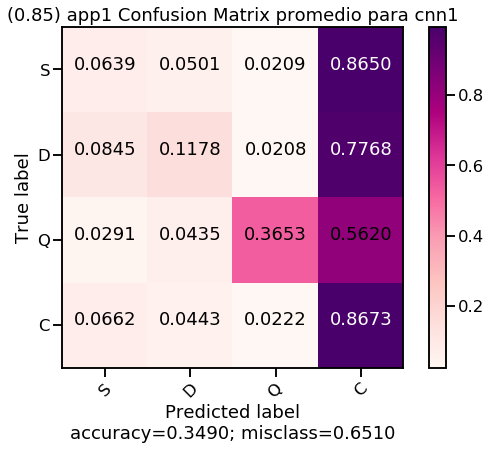

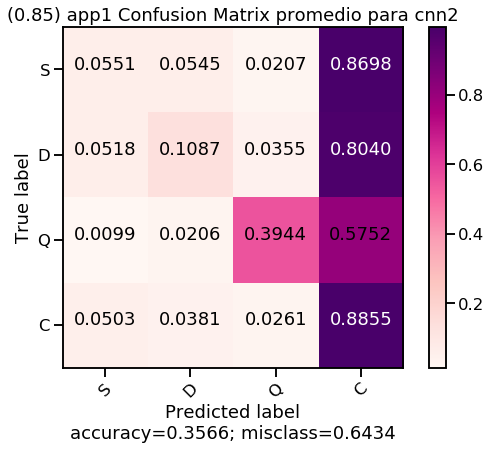

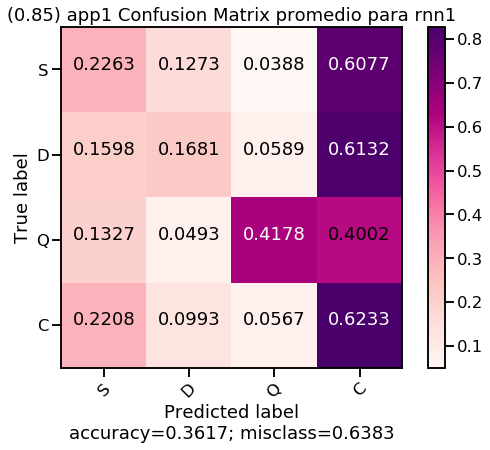

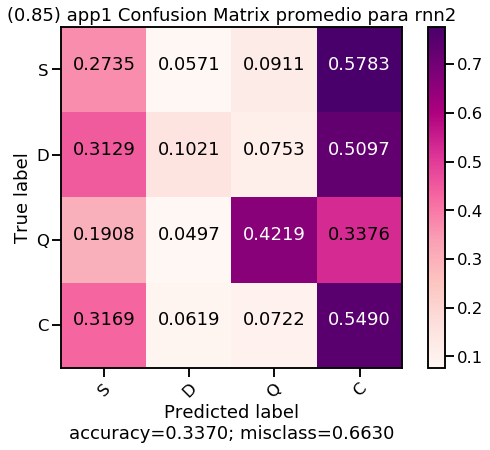

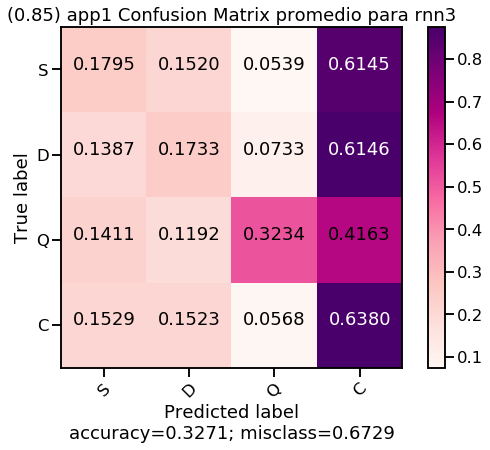

In [16]:
for key in confusions.keys():
    temp=np.sum(confusions[key], axis=0)/5.0
    plot_confusion_matrix(temp, ['S','D','Q','C'], "(0.85) app1 Confusion Matrix promedio para "+str(key), cmap='RdPu')

macro_augmented = np.load('../Data_augmented/Stance_agregado/Aumento_1-run_'+str(0.85)+'_balanced_w4_app1_Top'+str(1)+'.npy', allow_pickle=True)
ids_train=macro_augmented[:,0]
tws_train=macro_augmented[:,1]
labels_train=macro_augmented[:,2]


input_ids = []
for sent in tws_train:
    encoded_sent = tokenizer_loaded.encode(list(sent),add_special_tokens = False)    
    input_ids.append(encoded_sent)
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")

## App 1 masking 0.5

In [17]:
prob= 0.5
TOPN = 1

fs_macro={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
fs_none={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
accs={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
confusions={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}

aum_weight=det_samples(train['Label'], dict_cl)

for i in range(5): 
    macro_augmented=[]
    print ("--------------------------------------------------------")
    print ("\nGenerando ejemplos en base a probabilidad --> ", prob)
    print ("--------------------------------------------------------")
    for clase in aum_weight:
        start_time=time.time()
        print ("\nGenerando", aum_weight[clase], "nuevos ejemplos para la clase", clase)
        muestras, dict_aumentos=aumentar_clase(clase, aum_weight[clase], tags, prob, TOPN)
        macro_augmented+=muestras
        print ("Resumen de modificaciones:", dict_aumentos)
        elapsed_time= time.time() - start_time
        print ("Este proceso tomó", elapsed_time, "seg")   

    macro_augmented = np.asarray(macro_augmented, dtype=object)
    np.random.shuffle(macro_augmented)
    
    np.save('../Data_augmented/Stance_agregado/Aumento_'+str(i+1)+'-run_'+str(prob)+'_balanced_w4_app1_Top'+str(TOPN)+'.npy', macro_augmented)
    
    ids_train=macro_augmented[:,0]
    tws_train=macro_augmented[:,1]
    labels_train=macro_augmented[:,2]
    class_weights= compute_class_weight('balanced', np.unique(labels_train), labels_train)
    print ("Pesos de clases:", class_weights)
    
    etiq=labels_train.copy()
    sentences = tws_train
    n_labels = np.array(etiq)

    input_ids = []
    for sent in sentences:
        encoded_sent = tokenizer_loaded.encode(list(sent),add_special_tokens = False)    
        input_ids.append(encoded_sent)
    input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                              value=0, truncating="post", padding="post")
    y_train=to_categorical(n_labels,num_classes=4)
    shape=np.asarray(input_ids).shape
    x_train=np.zeros((shape[0], shape[1], 768))
    j=0
    for in_id in input_ids:
        x_train[j]=M_BERT_space[in_id]
        j+=1

    ###########################################################
    ############################################################
    ############################################################
    
    cnn1=create_ccn1(x_train.shape[1:])
    trained =train_model(cnn1, x_train, y_train, x_val, y_val, class_weights, e=30, BS=32, verb=0, focal=True)
    trained.save('exec_baselines/0.5/cnn1_'+str(i+1)+'-exec_w4_app1_Top_'+str(prob)+'_'+str(TOPN)+'.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'cnn1')
    fs_macro['cnn1'].append(f1_ma_t)
    fs_none['cnn1'].append(f1_t)
    accs['cnn1'].append(acc_t)
    confusions['cnn1'].append(matriz_t)
    
    cnn2=create_cnn2(x_train.shape[1:])
    trained =train_model(cnn2, x_train, y_train, x_val, y_val, class_weights, e=30, BS=32, verb=0, focal=True)
    trained.save('exec_baselines/0.5/cnn2_'+str(i+1)+'-exec_w4_app1_Top_'+str(prob)+'_'+str(TOPN)+'.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'cnn2')
    fs_macro['cnn2'].append(f1_ma_t)
    fs_none['cnn2'].append(f1_t)
    accs['cnn2'].append(acc_t)
    confusions['cnn2'].append(matriz_t)
    
    rnn1=create_complex_GRU_2(128,64,"adam",x_train.shape[1:])
    trained =train_model(rnn1, x_train, y_train, x_val, y_val, class_weights, e=30, BS=32, verb=0, focal=True)
    trained.save('exec_baselines/0.5/rnn1_'+str(i+1)+'-exec_w4_app1_Top_'+str(prob)+'_'+str(TOPN)+'.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'rnn1')
    fs_macro['rnn1'].append(f1_ma_t)
    fs_none['rnn1'].append(f1_t)
    accs['rnn1'].append(acc_t)
    confusions['rnn1'].append(matriz_t)
    
    rnn2=create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])
    trained =train_model(rnn2, x_train, y_train, x_val, y_val, class_weights, e=30, BS=32, verb=0, focal=True)
    trained.save('exec_baselines/0.5/rnn2_'+str(i+1)+'-exec_w4_app1_Top_'+str(prob)+'_'+str(TOPN)+'.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'rnn2')
    fs_macro['rnn2'].append(f1_ma_t)
    fs_none['rnn2'].append(f1_t)
    accs['rnn2'].append(acc_t)
    confusions['rnn2'].append(matriz_t)
    
    rnn3=create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])
    trained =train_model(rnn3, x_train, y_train, x_val, y_val, class_weights, e=30, BS=32, verb=0, focal=False)
    trained.save('exec_baselines/0.5/rnn3_'+str(i+1)+'-exec_w4_app1_Top_'+str(prob)+'_'+str(TOPN)+'.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'rnn3')
    fs_macro['rnn3'].append(f1_ma_t)
    fs_none['rnn3'].append(f1_t)
    accs['rnn3'].append(acc_t)
    confusions['rnn3'].append(matriz_t)

--------------------------------------------------------

Generando ejemplos en base a probabilidad -->  0.5
--------------------------------------------------------

Generando 2404 nuevos ejemplos para la clase questioning
# terms modificados promedio 2.7945091514143097 términos por sentencia
Largo de sentencia promedio 13.34442595673877 términos por sentencia
para esta ejecución se debiesen reemplazar 8909  de 17826 terminos
Resumen de modificaciones: {'NN': 4350, 'VBD': 114, 'VB': 298, 'NNS': 853, 'VBN': 265, 'VBG': 317, 'JJ': 461, 'VBZ': 38, 'JJR': 14, 'JJS': 8}
Este proceso tomó 34.619300365448 seg

Generando 0 nuevos ejemplos para la clase commenting
No se generan ejemplos
Resumen de modificaciones: {}
Este proceso tomó 0.7547636032104492 seg

Generando 1893 nuevos ejemplos para la clase support
# terms modificados promedio 3.9334389857369256 términos por sentencia
Largo de sentencia promedio 17.32540940306392 términos por sentencia
para esta ejecución se debiesen reemplazar 9414

# terms modificados promedio 3.884310618066561 términos por sentencia
Largo de sentencia promedio 17.263602746962494 términos por sentencia
para esta ejecución se debiesen reemplazar 9306  de 18710 terminos
Resumen de modificaciones: {'JJ': 517, 'NN': 4847, 'VB': 179, 'JJS': 53, 'NNS': 893, 'VBG': 383, 'VBD': 98, 'VBN': 300, 'VBZ': 68, 'JJR': 15}
Este proceso tomó 39.66791248321533 seg

Generando 2401 nuevos ejemplos para la clase denying
# terms modificados promedio 3.321949187838401 términos por sentencia
Largo de sentencia promedio 15.850895460224907 términos por sentencia
para esta ejecución se debiesen reemplazar 10354  de 20608 terminos
Resumen de modificaciones: {'NN': 5066, 'JJ': 684, 'VBD': 138, 'VB': 369, 'NNS': 921, 'VBN': 264, 'VBG': 442, 'VBZ': 63, 'JJS': 12, 'JJR': 17}
Este proceso tomó 39.1800320148468 seg
Pesos de clases: [1. 1. 1. 1.]
 - val_f1: 0.281740 
 - val_f1: 0.322772 
 - val_f1: 0.306240 
 - val_f1: 0.279220 
 - val_f1: 0.297872 
 - val_f1: 0.445421 
 - val_f1:

Pesos de clases: [1. 1. 1. 1.]
 - val_f1: 0.165836 
 - val_f1: 0.218407 
 - val_f1: 0.215006 
 - val_f1: 0.361838 
 - val_f1: 0.347931 
 - val_f1: 0.450513 
 - val_f1: 0.444864 
 - val_f1: 0.430380 
 - val_f1: 0.418620 
 - val_f1: 0.428213 
 - val_f1: 0.468903 
 - val_f1: 0.462963 
 - val_f1: 0.461232 
 - val_f1: 0.450349 
 - val_f1: 0.497221 
 - val_f1: 0.446791 
 - val_f1: 0.494960 
 - val_f1: 0.449031 
 - val_f1: 0.473483 
 - val_f1: 0.456772 
 - val_f1: 0.453135 
 - val_f1: 0.448491 
 - val_f1: 0.450416 
 - val_f1: 0.448766 
 - val_f1: 0.477523 
 - val_f1: 0.460419 
 - val_f1: 0.494103 
 - val_f1: 0.519666 
 - val_f1: 0.465521 
 - val_f1: 0.474054 

Accuracy sobre Train cnn1 : 0.9806144842721287
F1-score None sobre Train cnn1 : [0.97201767 0.98647898 0.99743308 0.96688742]
F1-score macro sobre Train cnn1 : 0.980704286124146

Accuracy sobre Val cnn1 : 0.6903914590747331
F1-score None sobre Val cnn1 : [0.52238806 0.15384615 0.625      0.77929155]
F1-score macro sobre Val cnn1 : 0.520


Accuracy sobre Test cnn1 : 0.7100881488736532
F1-score None sobre Test cnn1 : [0.11111111 0.07058824 0.41025641 0.83099451]
F1-score macro sobre Test cnn1 : 0.35573756637712417
 - val_f1: 0.121859 
 - val_f1: 0.166945 
 - val_f1: 0.196555 
 - val_f1: 0.240711 
 - val_f1: 0.321493 
 - val_f1: 0.397592 
 - val_f1: 0.439662 
 - val_f1: 0.421723 
 - val_f1: 0.430580 
 - val_f1: 0.474732 
 - val_f1: 0.497584 
 - val_f1: 0.440024 
 - val_f1: 0.488211 
 - val_f1: 0.417284 
 - val_f1: 0.484252 
 - val_f1: 0.474340 
 - val_f1: 0.482295 
 - val_f1: 0.485018 
 - val_f1: 0.387800 
 - val_f1: 0.496704 
 - val_f1: 0.486351 
 - val_f1: 0.464461 
 - val_f1: 0.463161 
 - val_f1: 0.447142 
 - val_f1: 0.425314 
 - val_f1: 0.457058 
 - val_f1: 0.513136 
 - val_f1: 0.475861 
 - val_f1: 0.483326 
 - val_f1: 0.498895 

Accuracy sobre Train cnn2 : 0.9784198975859546
F1-score None sobre Train cnn2 : [0.96637295 0.99412197 0.99434616 0.95876672]
F1-score macro sobre Train cnn2 : 0.9784019501754757

Accuracy so

 - val_f1: 0.458128 
 - val_f1: 0.497726 
 - val_f1: 0.463111 
 - val_f1: 0.492220 

Accuracy sobre Train cnn2 : 0.9748536942209217
F1-score None sobre Train cnn2 : [0.95900246 0.99319978 0.99252234 0.95490716]
F1-score macro sobre Train cnn2 : 0.9749079347784438

Accuracy sobre Val cnn2 : 0.6476868327402135
F1-score None sobre Val cnn2 : [0.36363636 0.23529412 0.63333333 0.752     ]
F1-score macro sobre Val cnn2 : 0.496065953654189

Accuracy sobre Test cnn2 : 0.7629774730656219
F1-score None sobre Test cnn2 : [0.04123711 0.07058824 0.61611374 0.8599151 ]
F1-score macro sobre Test cnn2 : 0.39696354820816293
 - val_f1: 0.000000 
 - val_f1: 0.000000 
 - val_f1: 0.000000 
 - val_f1: 0.212680 
 - val_f1: 0.189586 
 - val_f1: 0.275235 
 - val_f1: 0.241117 
 - val_f1: 0.202012 
 - val_f1: 0.243047 
 - val_f1: 0.228542 
 - val_f1: 0.480582 
 - val_f1: 0.454225 
 - val_f1: 0.407322 
 - val_f1: 0.516425 
 - val_f1: 0.485868 
 - val_f1: 0.437048 
 - val_f1: 0.423232 
 - val_f1: 0.452933 
 - val_

In [18]:
for key in fs_none.keys():
    temp=np.zeros(4)
    for result in fs_none[key]:
        temp+=result
    print ("(0.5) app1 F1-score promedio para",key,":" ,temp/5)
    
for key in fs_macro.keys():
    temp=np.sum(fs_macro[key])
    print ("(0.5) app1 F1-score macro promedio para",key,":" ,temp/5, "desvest: ",np.std(fs_macro[key]))

for key in accs.keys():
    temp=np.sum(accs[key])
    print ("(0.5) app1 Accuracy promedio para",key,":" ,temp/5)

(0.5) app1 F1-score promedio para cnn1 : [0.07936783 0.10917601 0.42759553 0.82597752]
(0.5) app1 F1-score promedio para cnn2 : [0.06776182 0.1243206  0.53090167 0.83370168]
(0.5) app1 F1-score promedio para rnn1 : [0.10450537 0.1221932  0.40648043 0.73065897]
(0.5) app1 F1-score promedio para rnn2 : [0.02092493 0.08959875 0.34808295 0.82598949]
(0.5) app1 F1-score promedio para rnn3 : [0.09143376 0.12682102 0.29209544 0.73534512]
(0.5) app1 F1-score macro promedio para cnn1 : 0.3605292226231171 desvest:  0.018780653907354873
(0.5) app1 F1-score macro promedio para cnn2 : 0.38917144146672955 desvest:  0.014723846212418101
(0.5) app1 F1-score macro promedio para rnn1 : 0.3409594916169583 desvest:  0.018651138400795773
(0.5) app1 F1-score macro promedio para rnn2 : 0.32114903070156886 desvest:  0.02766084141915266
(0.5) app1 F1-score macro promedio para rnn3 : 0.31142383330652007 desvest:  0.02549993304685431
(0.5) app1 Accuracy promedio para cnn1 : 0.7044074436826641
(0.5) app1 Accuracy

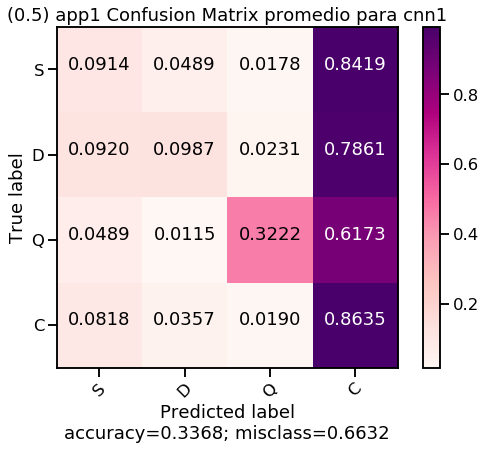

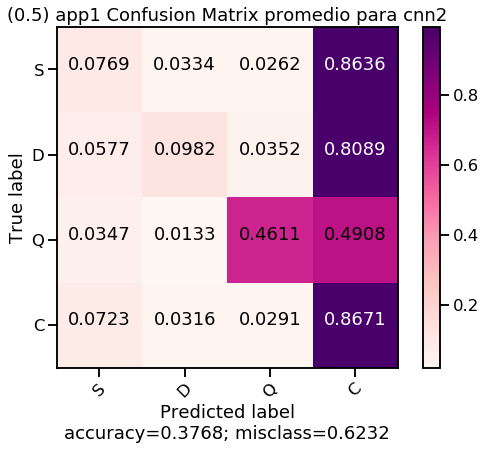

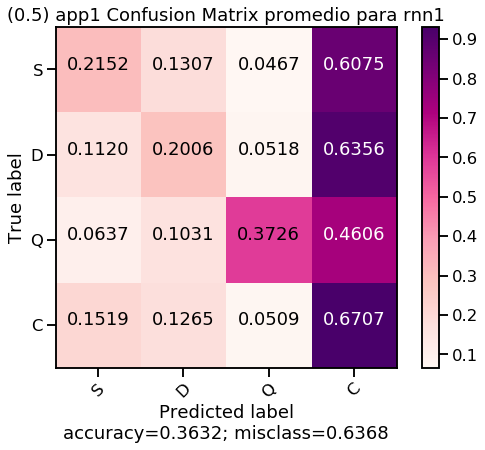

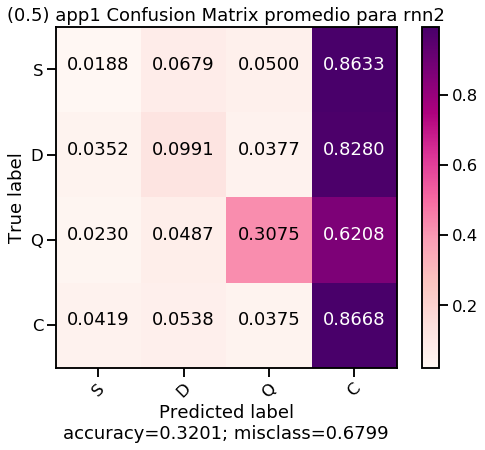

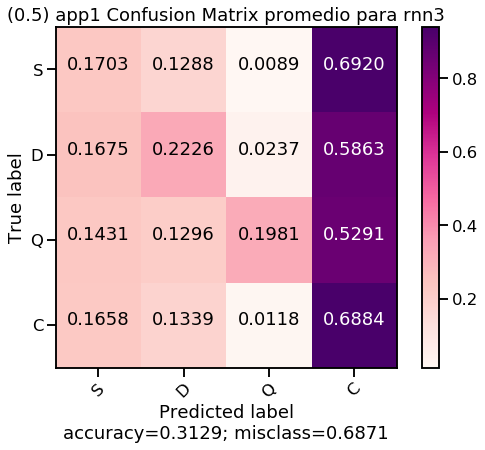

In [19]:
for key in confusions.keys():
    temp=np.sum(confusions[key], axis=0)/5.0
    plot_confusion_matrix(temp, ['S','D','Q','C'], "(0.5) app1 Confusion Matrix promedio para "+str(key), cmap='RdPu')

## Sin Data augmentation sin CW

In [12]:
prob= 0.0
TOPN = 1

fs_macro_wo={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
fs_none_wo={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
accs_wo={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
confusions_wo={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}

aum_weight = {'support': 0, 'denying': 0, 'questioning': 0, 'commenting': 0}

for i in range(5): 
    macro_augmented=[]
    print ("--------------------------------------------------------")
    print ("\nGenerando ejemplos en base a probabilidad --> ", prob)
    print ("--------------------------------------------------------")
    for clase in aum_weight:
        start_time=time.time()
        print ("\nGenerando", aum_weight[clase], "nuevos ejemplos para la clase", clase)
        muestras, dict_aumentos=aumentar_clase(clase, aum_weight[clase], tags, prob, TOPN)
        macro_augmented+=muestras
        print ("Resumen de modificaciones:", dict_aumentos)
        elapsed_time= time.time() - start_time
        print ("Este proceso tomó", elapsed_time, "seg")   

    macro_augmented = np.asarray(macro_augmented, dtype=object)
    np.random.shuffle(macro_augmented)
    
    np.save('../Data_augmented/Stance_agregado/Sin_Aumento_'+str(i+1)+'-run_'+str(prob)+'_balanced_w4_app1_Top'+str(TOPN)+'.npy', macro_augmented)
    
    ids_train=macro_augmented[:,0]
    tws_train=macro_augmented[:,1]
    labels_train=macro_augmented[:,2]
    class_weights= [1.0, 1.0, 1.0, 1.0] #compute_class_weight('balanced', np.unique(labels_train), labels_train)
    print ("Pesos de clases:", class_weights)
    
    etiq=labels_train.copy()
    sentences = tws_train
    n_labels = np.array(etiq)

    input_ids = []
    for sent in sentences:
        encoded_sent = tokenizer_loaded.encode(list(sent),add_special_tokens = False)    
        input_ids.append(encoded_sent)
    input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                              value=0, truncating="post", padding="post")
    y_train=to_categorical(n_labels,num_classes=4)
    shape=np.asarray(input_ids).shape
    x_train=np.zeros((shape[0], shape[1], 768))
    j=0
    for in_id in input_ids:
        x_train[j]=M_BERT_space[in_id]
        j+=1

    cnn1=create_ccn1(x_train.shape[1:])
    trained =train_model(cnn1, x_train, y_train, x_val, y_val, class_weights, e=30, BS=32, verb=0, focal=True)
    trained.save('exec_baselines/0.0_wo/cnn1_'+str(i+1)+'-exec_w4_app1_Top_'+str(prob)+'_'+str(TOPN)+'.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'cnn1')
    fs_macro_wo['cnn1'].append(f1_ma_t)
    fs_none_wo['cnn1'].append(f1_t)
    accs_wo['cnn1'].append(acc_t)
    confusions_wo['cnn1'].append(matriz_t)
    
    cnn2=create_cnn2(x_train.shape[1:])
    trained =train_model(cnn2, x_train, y_train, x_val, y_val, class_weights, e=30, BS=32, verb=0, focal=True)
    trained.save('exec_baselines/0.0_wo/cnn2_'+str(i+1)+'-exec_w4_app1_Top_'+str(prob)+'_'+str(TOPN)+'.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'cnn2')
    fs_macro_wo['cnn2'].append(f1_ma_t)
    fs_none_wo['cnn2'].append(f1_t)
    accs_wo['cnn2'].append(acc_t)
    confusions_wo['cnn2'].append(matriz_t)
    
    rnn1=create_complex_GRU_2(128,64,"adam",x_train.shape[1:])
    trained =train_model(rnn1, x_train, y_train, x_val, y_val, class_weights, e=30, BS=32, verb=0, focal=True)
    trained.save('exec_baselines/0.0_wo/rnn1_'+str(i+1)+'-exec_w4_app1_Top_'+str(prob)+'_'+str(TOPN)+'.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'rnn1')
    fs_macro_wo['rnn1'].append(f1_ma_t)
    fs_none_wo['rnn1'].append(f1_t)
    accs_wo['rnn1'].append(acc_t)
    confusions_wo['rnn1'].append(matriz_t)
    
    rnn2=create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])
    trained =train_model(rnn2, x_train, y_train, x_val, y_val, class_weights, e=30, BS=32, verb=0, focal=True)
    trained.save('exec_baselines/0.0_wo/rnn2_'+str(i+1)+'-exec_w4_app1_Top_'+str(prob)+'_'+str(TOPN)+'.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'rnn2')
    fs_macro_wo['rnn2'].append(f1_ma_t)
    fs_none_wo['rnn2'].append(f1_t)
    accs_wo['rnn2'].append(acc_t)
    confusions_wo['rnn2'].append(matriz_t)
    
    rnn3=create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])
    trained =train_model(rnn3, x_train, y_train, x_val, y_val, class_weights, e=30, BS=32, verb=0, focal=False)
    trained.save('exec_baselines/0.0_wo/rnn3_'+str(i+1)+'-exec_w4_app1_Top_'+str(prob)+'_'+str(TOPN)+'.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'rnn3')
    fs_macro_wo['rnn3'].append(f1_ma_t)
    fs_none_wo['rnn3'].append(f1_t)
    accs_wo['rnn3'].append(acc_t)
    confusions_wo['rnn3'].append(matriz_t)

--------------------------------------------------------

Generando ejemplos en base a probabilidad -->  0.0
--------------------------------------------------------

Generando 0 nuevos ejemplos para la clase support
No se generan ejemplos
Resumen de modificaciones: {}
Este proceso tomó 0.2713441848754883 seg

Generando 0 nuevos ejemplos para la clase denying
No se generan ejemplos
Resumen de modificaciones: {}
Este proceso tomó 0.0987703800201416 seg

Generando 0 nuevos ejemplos para la clase questioning
No se generan ejemplos
Resumen de modificaciones: {}
Este proceso tomó 0.08395600318908691 seg

Generando 0 nuevos ejemplos para la clase commenting
No se generan ejemplos
Resumen de modificaciones: {}
Este proceso tomó 0.7527890205383301 seg
Pesos de clases: [1.0, 1.0, 1.0, 1.0]





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as n


Accuracy sobre Test cnn2 : 0.7668952007835456
F1-score None sobre Test cnn2 : [0.04761905 0.         0.37837838 0.8650201 ]
F1-score macro sobre Test cnn2 : 0.3227543823465707

Accuracy sobre Train rnn1 : 0.9004247286455875
F1-score None sobre Train rnn1 : [0.85558912 0.81073025 0.88590604 0.92617933]
F1-score macro sobre Train rnn1 : 0.8696011869252974

Accuracy sobre Val rnn1 : 0.6583629893238434
F1-score None sobre Val rnn1 : [0.5        0.16666667 0.42105263 0.76315789]
F1-score macro sobre Val rnn1 : 0.4627192982456141

Accuracy sobre Test rnn1 : 0.683643486777669
F1-score None sobre Test rnn1 : [0.04444444 0.1369863  0.31428571 0.81801357]
F1-score macro sobre Test rnn1 : 0.32843250799230955

Accuracy sobre Train rnn2 : 0.74067956583294
F1-score None sobre Train rnn2 : [0.72552553 0.51792829 0.63703704 0.79757481]
F1-score macro sobre Train rnn2 : 0.6695164146811888

Accuracy sobre Val rnn2 : 0.597864768683274
F1-score None sobre Val rnn2 : [0.60431655 0.         0.47222222 0.68


Accuracy sobre Test rnn3 : 0.7012732615083251
F1-score None sobre Test rnn3 : [0.07407407 0.04819277 0.38683128 0.82462687]
F1-score macro sobre Test rnn3 : 0.33343124663755447
--------------------------------------------------------

Generando ejemplos en base a probabilidad -->  0.0
--------------------------------------------------------

Generando 0 nuevos ejemplos para la clase support
No se generan ejemplos
Resumen de modificaciones: {}
Este proceso tomó 0.27503323554992676 seg

Generando 0 nuevos ejemplos para la clase denying
No se generan ejemplos
Resumen de modificaciones: {}
Este proceso tomó 0.10032844543457031 seg

Generando 0 nuevos ejemplos para la clase questioning
No se generan ejemplos
Resumen de modificaciones: {}
Este proceso tomó 0.0860295295715332 seg

Generando 0 nuevos ejemplos para la clase commenting
No se generan ejemplos
Resumen de modificaciones: {}
Este proceso tomó 0.7641134262084961 seg
Pesos de clases: [1.0, 1.0, 1.0, 1.0]

Accuracy sobre Train cnn1 : 

In [13]:
for key in fs_none_wo.keys():
    temp=np.zeros(4)
    for result in fs_none_wo[key]:
        temp+=result
    print ("(0.0) app1 F1-score promedio para",key,":" ,temp/5)
    
print ("")
for key in fs_macro_wo.keys():
    temp=np.sum(fs_macro_wo[key])
    print ("(0.0) app1 F1-score macro promedio para",key,":" ,temp/5, "desvest: ",np.std(fs_macro_wo[key]))

print ("")
for key in accs_wo.keys():
    temp=np.sum(accs_wo[key])
    print ("(0.0) app1 Accuracy promedio para",key,":" ,temp/5)

(0.0) app1 F1-score promedio para cnn1 : [0.00519481 0.         0.24584725 0.8660157 ]
(0.0) app1 F1-score promedio para cnn2 : [0.02842333 0.00487805 0.32968126 0.86378731]
(0.0) app1 F1-score promedio para rnn1 : [0.12081242 0.02739726 0.39617257 0.62949907]
(0.0) app1 F1-score promedio para rnn2 : [0.11787911 0.10892228 0.36765942 0.64487705]
(0.0) app1 F1-score promedio para rnn3 : [0.10415908 0.08288608 0.46521893 0.78753055]

(0.0) app1 F1-score macro promedio para cnn1 : 0.27926443846452165 desvest:  0.023139088177666776
(0.0) app1 F1-score macro promedio para cnn2 : 0.3066924888975449 desvest:  0.02428768386351404
(0.0) app1 F1-score macro promedio para rnn1 : 0.29347032952968505 desvest:  0.0580130888597671
(0.0) app1 F1-score macro promedio para rnn2 : 0.3098344672510879 desvest:  0.04640198954066419
(0.0) app1 F1-score macro promedio para rnn3 : 0.3599486604167458 desvest:  0.04079660048907177

(0.0) app1 Accuracy promedio para cnn1 : 0.7655239960822723
(0.0) app1 Accuracy p

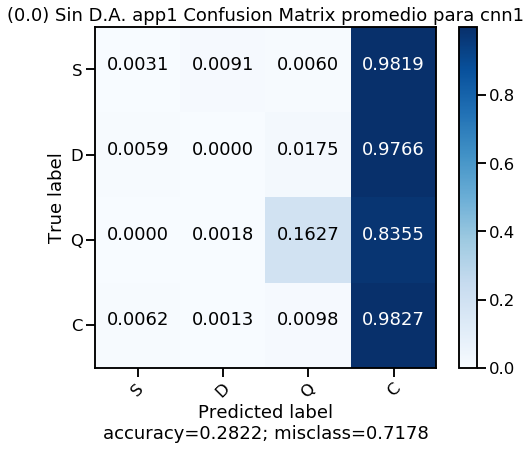

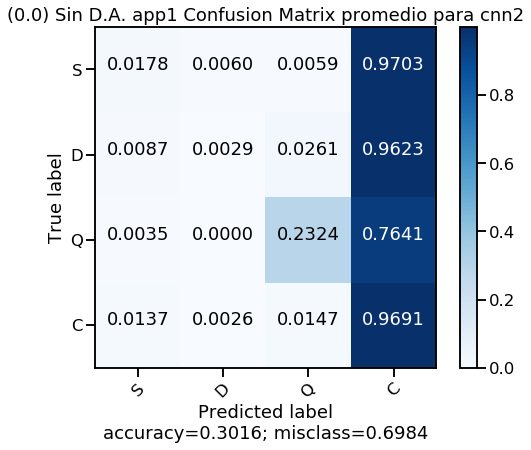

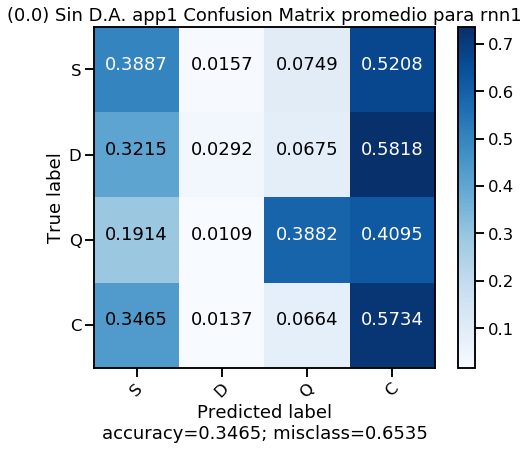

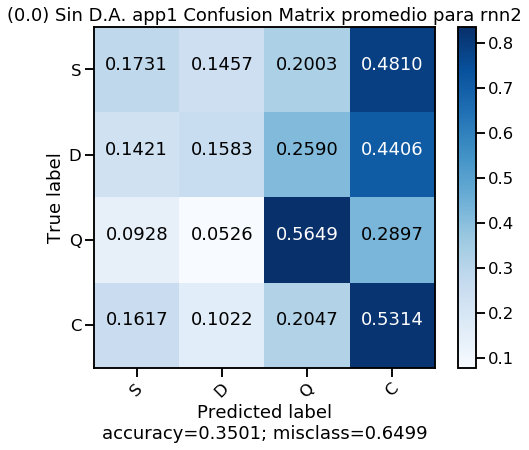

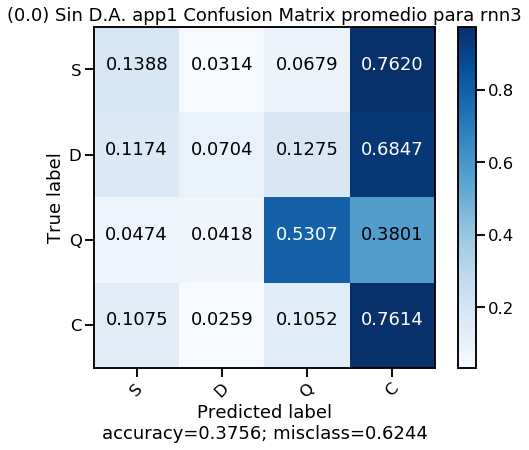

In [14]:
for key in confusions_wo.keys():
    temp=np.sum(confusions_wo[key], axis=0)/5.0
    plot_confusion_matrix(temp, ['S','D','Q','C'], "(0.0) Sin D.A. app1 Confusion Matrix promedio para "+str(key))

#### Nota

Redes convolucionales tienen mal desempeño en data desbalanceada

## Sin Data augmentation Con CW¶

In [ ]:
prob= 0.0
TOPN = 1

fs_macro_cw={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
fs_none_cw={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
accs_cw={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
confusions_cw={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}

aum_weight = {'support': 0, 'denying': 0, 'questioning': 0, 'commenting': 0}

for i in range(5): 
    """macro_augmented=[]
    print ("--------------------------------------------------------")
    print ("\nGenerando ejemplos en base a probabilidad --> ", prob)
    print ("--------------------------------------------------------")
    for clase in aum_weight:
        start_time=time.time()
        print ("\nGenerando", aum_weight[clase], "nuevos ejemplos para la clase", clase)
        muestras, dict_aumentos=aumentar_clase(clase, aum_weight[clase], tags, prob, TOPN)
        macro_augmented+=muestras
        print ("Resumen de modificaciones:", dict_aumentos)
        elapsed_time= time.time() - start_time
        print ("Este proceso tomó", elapsed_time, "seg")   

    macro_augmented = np.asarray(macro_augmented, dtype=object)
    np.random.shuffle(macro_augmented)
    """
    macro_augmented=np.load('../Data_augmented/Stance_agregado/Sin_Aumento_'+str(i+1)+'-run_0.0_balanced_w4_app1_Top1.npy', allow_pickle=True)
    
    ids_train=macro_augmented[:,0]
    tws_train=macro_augmented[:,1]
    labels_train=macro_augmented[:,2]
    class_weights= compute_class_weight('balanced', np.unique(labels_train), labels_train)
    print ("Pesos de clases:", class_weights)
    
    etiq=labels_train.copy()
    sentences = tws_train
    n_labels = np.array(etiq)

    input_ids = []
    for sent in sentences:
        encoded_sent = tokenizer_loaded.encode(list(sent),add_special_tokens = False)    
        input_ids.append(encoded_sent)
    input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                              value=0, truncating="post", padding="post")
    y_train=to_categorical(n_labels,num_classes=4)
    shape=np.asarray(input_ids).shape
    x_train=np.zeros((shape[0], shape[1], 768))
    j=0
    for in_id in input_ids:
        x_train[j]=M_BERT_space[in_id]
        j+=1

    cnn1=create_ccn1(x_train.shape[1:])
    trained =train_model(cnn1, x_train, y_train, x_val, y_val, class_weights, e=30, BS=32, verb=0, focal=True)
    trained.save('exec_baselines/0.0/cnn1_'+str(i+1)+'-exec_w4_app1_Top_'+str(prob)+'_'+str(TOPN)+'.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'cnn1')
    fs_macro_cw['cnn1'].append(f1_ma_t)
    fs_none_cw['cnn1'].append(f1_t)
    accs_cw['cnn1'].append(acc_t)
    confusions_cw['cnn1'].append(matriz_t)
    
    cnn2=create_cnn2(x_train.shape[1:])
    trained =train_model(cnn2, x_train, y_train, x_val, y_val, class_weights, e=30, BS=32, verb=0, focal=True)
    trained.save('exec_baselines/0.0/cnn2_'+str(i+1)+'-exec_w4_app1_Top_'+str(prob)+'_'+str(TOPN)+'.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'cnn2')
    fs_macro_cw['cnn2'].append(f1_ma_t)
    fs_none_cw['cnn2'].append(f1_t)
    accs_cw['cnn2'].append(acc_t)
    confusions_cw['cnn2'].append(matriz_t)
    
    rnn1=create_complex_GRU_2(128,64,"adam",x_train.shape[1:])
    trained =train_model(rnn1, x_train, y_train, x_val, y_val, class_weights, e=30, BS=32, verb=0, focal=True)
    trained.save('exec_baselines/0.0/rnn1_'+str(i+1)+'-exec_w4_app1_Top_'+str(prob)+'_'+str(TOPN)+'.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'rnn1')
    fs_macro_cw['rnn1'].append(f1_ma_t)
    fs_none_cw['rnn1'].append(f1_t)
    accs_cw['rnn1'].append(acc_t)
    confusions_cw['rnn1'].append(matriz_t)
    
    rnn2=create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])
    trained =train_model(rnn2, x_train, y_train, x_val, y_val, class_weights, e=30, BS=32, verb=0, focal=True)
    trained.save('exec_baselines/0.0/rnn2_'+str(i+1)+'-exec_w4_app1_Top_'+str(prob)+'_'+str(TOPN)+'.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'rnn2')
    fs_macro_cw['rnn2'].append(f1_ma_t)
    fs_none_cw['rnn2'].append(f1_t)
    accs_cw['rnn2'].append(acc_t)
    confusions_cw['rnn2'].append(matriz_t)
    
    rnn3=create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])
    trained =train_model(rnn3, x_train, y_train, x_val, y_val, class_weights, e=30, BS=32, verb=0, focal=False)
    trained.save('exec_baselines/0.0/rnn3_'+str(i+1)+'-exec_w4_app1_Top_'+str(prob)+'_'+str(TOPN)+'.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'rnn3')
    fs_macro_cw['rnn3'].append(f1_ma_t)
    fs_none_cw['rnn3'].append(f1_t)
    accs_cw['rnn3'].append(acc_t)
    confusions_cw['rnn3'].append(matriz_t)

Pesos de clases: [1.25980975 3.18168168 3.21060606 0.38752743]





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [11]:
for key in fs_none_cw.keys():
    temp=np.zeros(4)
    for result in fs_none_cw[key]:
        temp+=result
    print ("(0.0) app1 F1-score promedio para",key,":" ,temp/5)
    
print ("")
for key in fs_macro_cw.keys():
    temp=np.sum(fs_macro_cw[key])
    print ("(0.0) app1 F1-score macro promedio para",key,":" ,temp/5, "desvest: ",np.std(fs_macro_cw[key]))

print ("")
for key in accs_cw.keys():
    temp=np.sum(accs_cw[key])
    print ("(0.0) app1 Accuracy promedio para",key,":" ,temp/5)

(0.0) app1 F1-score promedio para cnn1 : [0.09634796 0.08932259 0.59894064 0.82120242]
(0.0) app1 F1-score promedio para cnn2 : [0.13768889 0.085248   0.60643368 0.80013306]
(0.0) app1 F1-score promedio para rnn1 : [0.16219212 0.15407476 0.38468154 0.31580952]
(0.0) app1 F1-score promedio para rnn2 : [0.17854112 0.12848062 0.39989356 0.25487799]
(0.0) app1 F1-score promedio para rnn3 : [0.0843383  0.11650334 0.41358879 0.73863019]

(0.0) app1 F1-score macro promedio para cnn1 : 0.40145340305767635 desvest:  0.012136962902873236
(0.0) app1 F1-score macro promedio para cnn2 : 0.40737590756667563 desvest:  0.011190003304254665
(0.0) app1 F1-score macro promedio para rnn1 : 0.2541894870710474 desvest:  0.05467515007360271
(0.0) app1 F1-score macro promedio para rnn2 : 0.2404483244325532 desvest:  0.040806394351964856
(0.0) app1 F1-score macro promedio para rnn3 : 0.33826515690433 desvest:  0.024686104230961153

(0.0) app1 Accuracy promedio para cnn1 : 0.7085210577864839
(0.0) app1 Accuracy

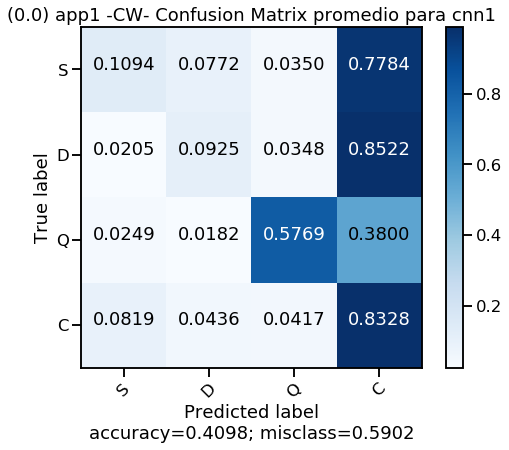

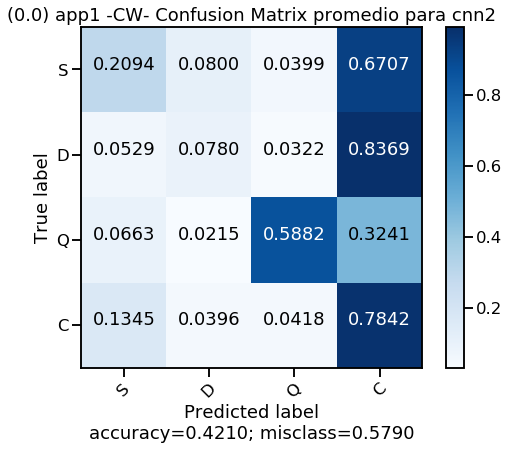

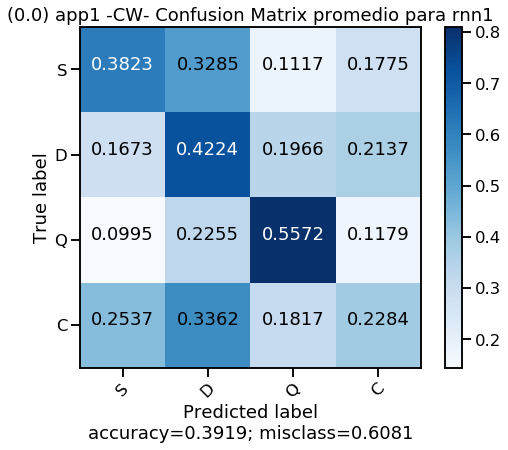

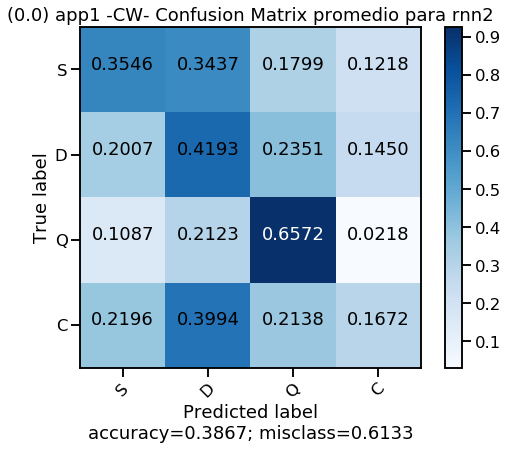

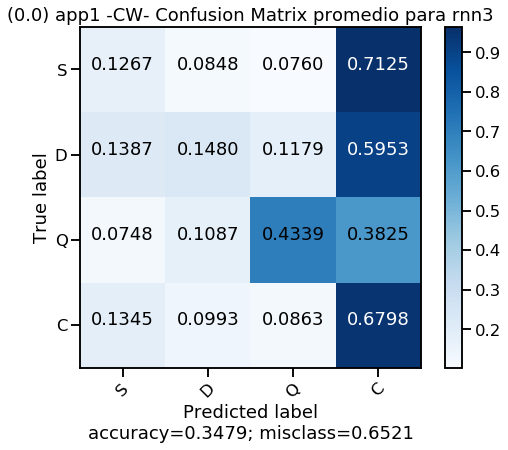

In [12]:
for key in confusions_cw.keys():
    temp=np.sum(confusions_cw[key], axis=0)/5.0
    plot_confusion_matrix(temp, ['S','D','Q','C'], "(0.0) app1 -CW- Confusion Matrix promedio para "+str(key))

### Nota

La aplicación de class_weigths y focal loss para las redes recurrentes parece tener un efecto no deseado. Sin embargo las redes convolucionales se ven claramente beneficiadas por este parámetro. 

La aplicación de class_weights para una red recurrente cuya función de perdida es categorical cross entropy, no parece verse ni beneficiada ni perjudicada (no se acusan resultados significativamente diferentes)

## SMOTE Balanced 

In [11]:
from imblearn.over_sampling import SMOTE

x_val=np.expand_dims(x_val, axis=-1)
x_test=np.expand_dims(x_test, axis=-1)

In [14]:
prob= 0.0
TOPN = 1

fs_macro_sm={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
fs_none_sm={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
accs_sm={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
confusions_sm={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}

aum_weight = {'support': 0, 'denying': 0, 'questioning': 0, 'commenting': 0}

for i in range(5): 
    print ("--------------------------------------------------------")
    print ("\nGenerando modelos EJECUCIÓN",i)
    print ("--------------------------------------------------------")
    
    """macro_augmented=[]
    print ("--------------------------------------------------------")
    print ("\nGenerando ejemplos en base a probabilidad --> ", prob, '--- EJECUCIÓN ',i)
    print ("--------------------------------------------------------")
    for clase in aum_weight:
        start_time=time.time()
        print ("\nGenerando", aum_weight[clase], "nuevos ejemplos para la clase", clase)
        muestras, dict_aumentos=aumentar_clase(clase, aum_weight[clase], tags, prob, TOPN)
        macro_augmented+=muestras
        print ("Resumen de modificaciones:", dict_aumentos)
        elapsed_time= time.time() - start_time
        print ("Este proceso tomó", elapsed_time, "seg")   

    macro_augmented = np.asarray(macro_augmented, dtype=object)
    np.random.shuffle(macro_augmented)
    
    np.save('../Data_augmented/Stance_agregado/SMOTE_'+str(i+1)+'-run.npy', macro_augmented) """   
    macro_augmented=np.load('../Data_augmented/Stance_agregado/SMOTE_'+str(i+1)+'-run.npy', allow_pickle=True)
    ids_train=macro_augmented[:,0]
    tws_train=macro_augmented[:,1]
    labels_train=macro_augmented[:,2]
    
    etiq=labels_train.copy()
    sentences = tws_train
    n_labels = np.array(etiq)

    input_ids = []
    for sent in sentences:
        encoded_sent = tokenizer_loaded.encode(list(sent),add_special_tokens = False)    
        input_ids.append(encoded_sent)
    input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                              value=0, truncating="post", padding="post")
    
    y_train=to_categorical(n_labels, num_classes=4)
    shape=np.asarray(input_ids).shape
    x_train=np.zeros((shape[0], 768))
    j=0
    for in_id in input_ids:
        vector=np.zeros(768)
        n = np.sum(in_id != 0)
        for idv in in_id:
            if idv!=0:
                vector+=M_BERT_space[idv]
        x_train[j]=(vector/n)
        j+=1  
     
    sm = SMOTE(random_state=27, n_jobs=-1, sampling_strategy='not majority')
    x_train, y_train = sm.fit_sample(x_train, y_train)
    etiq=np.asarray([np.argmax(y) for y in y_train])
    class_weights = compute_class_weight('balanced', np.unique(etiq), etiq)
    print ("class_weights Training set", class_weights)

    x_train=np.expand_dims(x_train, axis=-1)
    

    ###############################
    ###############################
    ###############################
    
    cnn1=create_ccn1(x_train.shape[1:])
    trained =train_model(cnn1, x_train, y_train, x_val, y_val, class_weights, e=30, BS=32, verb=0, focal=True)
    trained.save('exec_baselines/SMOTE/cnn1_'+str(i+1)+'-exec_w4_app1.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'cnn1')
    fs_macro_sm['cnn1'].append(f1_ma_t)
    fs_none_sm['cnn1'].append(f1_t)
    accs_sm['cnn1'].append(acc_t)
    confusions_sm['cnn1'].append(matriz_t)
    
    cnn2=create_cnn2(x_train.shape[1:])
    trained =train_model(cnn2, x_train, y_train, x_val, y_val, class_weights, e=30, BS=32, verb=0, focal=True)
    trained.save('exec_baselines/SMOTE/cnn2_'+str(i+1)+'-exec_w4_app1.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'cnn2')
    fs_macro_sm['cnn2'].append(f1_ma_t)
    fs_none_sm['cnn2'].append(f1_t)
    accs_sm['cnn2'].append(acc_t)
    confusions_sm['cnn2'].append(matriz_t)
    
    rnn1=create_complex_GRU_2(128,64,"adam",x_train.shape[1:])
    trained =train_model(rnn1, x_train, y_train, x_val, y_val, class_weights, e=30, BS=32, verb=0, focal=True)
    trained.save('exec_baselines/SMOTE/rnn1_'+str(i+1)+'-exec_w4_app1.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'rnn1')
    fs_macro_sm['rnn1'].append(f1_ma_t)
    fs_none_sm['rnn1'].append(f1_t)
    accs_sm['rnn1'].append(acc_t)
    confusions_sm['rnn1'].append(matriz_t)
    
    rnn2=create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])
    trained =train_model(rnn2, x_train, y_train, x_val, y_val, class_weights, e=30, BS=32, verb=0, focal=True)
    trained.save('exec_baselines/SMOTE/rnn2_'+str(i+1)+'-exec_w4_app1.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'rnn2')
    fs_macro_sm['rnn2'].append(f1_ma_t)
    fs_none_sm['rnn2'].append(f1_t)
    accs_sm['rnn2'].append(acc_t)
    confusions_sm['rnn2'].append(matriz_t)
    
    rnn3=create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])
    trained =train_model(rnn3, x_train, y_train, x_val, y_val, class_weights, e=30, BS=32, verb=0, focal=False)
    trained.save('exec_baselines/SMOTE/rnn3_'+str(i+1)+'-exec_w4_app1.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'rnn3')
    fs_macro_sm['rnn3'].append(f1_ma_t)
    fs_none_sm['rnn3'].append(f1_t)
    accs_sm['rnn3'].append(acc_t)
    confusions_sm['rnn3'].append(matriz_t)

--------------------------------------------------------

Generando modelos EJECUCIÓN 0
--------------------------------------------------------
class_weights Training set [1. 1. 1. 1.]

Accuracy sobre Train cnn1 : 0.9695501097293343
F1-score None sobre Train cnn1 : [0.95768948 0.97869267 0.98878031 0.9523455 ]
F1-score macro sobre Train cnn1 : 0.9693769882016279

Accuracy sobre Val cnn1 : 0.5871886120996441
F1-score None sobre Val cnn1 : [0.33333333 0.12903226 0.53571429 0.71468144]
F1-score macro sobre Val cnn1 : 0.42819032938883717

Accuracy sobre Test cnn1 : 0.6758080313418218
F1-score None sobre Test cnn1 : [0.21333333 0.12328767 0.44329897 0.80154639]
F1-score macro sobre Test cnn1 : 0.3953665913477381

Accuracy sobre Train cnn2 : 0.9541880029261156
F1-score None sobre Train cnn2 : [0.93118757 0.98180495 0.98267148 0.92007366]
F1-score macro sobre Train cnn2 : 0.9539344158476692

Accuracy sobre Val cnn2 : 0.6298932384341637
F1-score None sobre Val cnn2 : [0.37037037 0.13793103 0.


Accuracy sobre Test rnn2 : 0.5063663075416258
F1-score None sobre Test rnn2 : [0.21164021 0.12648221 0.25092251 0.67268623]
F1-score macro sobre Test rnn2 : 0.31543279113808653

Accuracy sobre Train rnn3 : 0.42794440380395027
F1-score None sobre Train rnn3 : [0.34720759 0.24469821 0.55459211 0.45821424]
F1-score macro sobre Train rnn3 : 0.40117803623891096

Accuracy sobre Val rnn3 : 0.604982206405694
F1-score None sobre Val rnn3 : [0.41584158 0.         0.4047619  0.72928177]
F1-score macro sobre Val rnn3 : 0.3874713142190304

Accuracy sobre Test rnn3 : 0.6258570029382958
F1-score None sobre Test rnn3 : [0.10526316 0.08602151 0.27810651 0.76912929]
F1-score macro sobre Test rnn3 : 0.3096301149364413
--------------------------------------------------------

Generando modelos EJECUCIÓN 3
--------------------------------------------------------
class_weights Training set [1. 1. 1. 1.]

Accuracy sobre Train cnn1 : 0.9726591075347476
F1-score None sobre Train cnn1 : [0.9603059  0.98694233 

In [15]:
for key in fs_none_sm.keys():
    temp=np.zeros(4)
    for result in fs_none_sm[key]:
        temp+=result
    print ("(SMOTE) F1-score promedio para",key,":" ,temp/5)

print ("")
for key in fs_macro_sm.keys():
    temp=np.sum(fs_macro_sm[key])
    print ("(SMOTE) F1-score macro promedio para",key,":" ,temp/5, "desvest: ",np.std(fs_macro_sm[key]))

print ("")
for key in accs_sm.keys():
    temp=np.sum(accs_sm[key])
    print ("(SMOTE) Accuracy promedio para",key,":" ,temp/5)

(SMOTE) F1-score promedio para cnn1 : [0.22323424 0.09066228 0.44238278 0.79734055]
(SMOTE) F1-score promedio para cnn2 : [0.22804979 0.08730085 0.46988418 0.80312307]
(SMOTE) F1-score promedio para rnn1 : [0.16231079 0.110261   0.25267763 0.6238415 ]
(SMOTE) F1-score promedio para rnn2 : [0.10896585 0.08337858 0.23436209 0.50015826]
(SMOTE) F1-score promedio para rnn3 : [0.17778909 0.09106006 0.24048234 0.685808  ]

(SMOTE) F1-score macro promedio para cnn1 : 0.38840496421734094 desvest:  0.007503369227102938
(SMOTE) F1-score macro promedio para cnn2 : 0.3970894715985434 desvest:  0.017004257648364086
(SMOTE) F1-score macro promedio para rnn1 : 0.2872727314672903 desvest:  0.023279798173038973
(SMOTE) F1-score macro promedio para rnn2 : 0.2317161948090667 desvest:  0.0729773931410319
(SMOTE) F1-score macro promedio para rnn3 : 0.29878487052262476 desvest:  0.025143209578281707

(SMOTE) Accuracy promedio para cnn1 : 0.6693437806072478
(SMOTE) Accuracy promedio para cnn2 : 0.68011753183

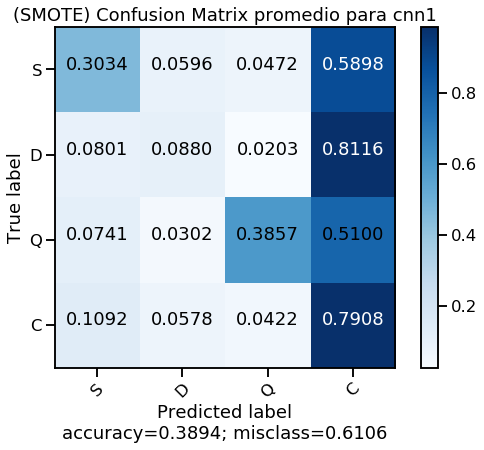

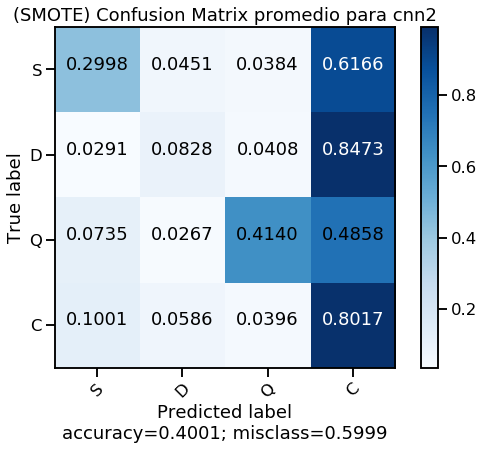

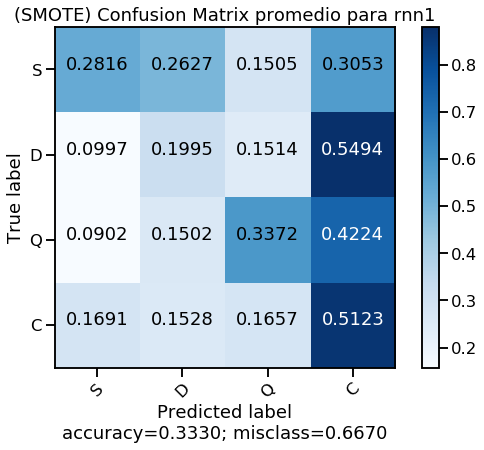

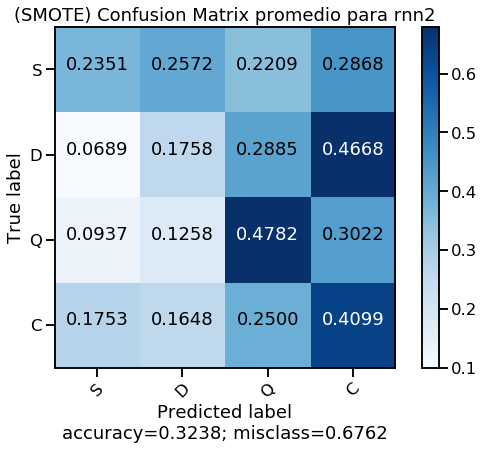

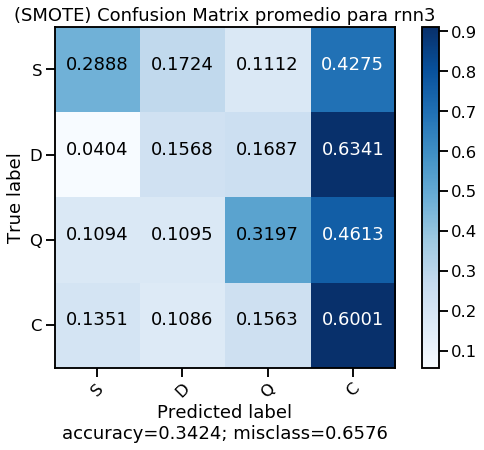

In [16]:
for key in confusions_sm.keys():
    temp=np.sum(confusions_sm[key], axis=0)/5.0
    plot_confusion_matrix(temp, ['S','D','Q','C'], "(SMOTE) Confusion Matrix promedio para "+str(key))

## idem : prob 0.5 bias 1.0

In [7]:
for key in fs_none.keys():
    print (key)
    temp=np.zeros(4)
    for result in fs_none[key]:
        temp+=result
    print ("(0.5) F1-score promedio para",key,":" ,temp/5)
    
for key in fs_macro.keys():
    temp=np.sum(fs_macro[key])
    print ("(0.5) F1-score macro promedio para",key,":" ,temp/5)

for key in accs.keys():
    temp=np.sum(accs[key])
    print ("(0.5) Accuracy promedio para",key,":" ,temp/5)

cnn1
(0.5) F1-score promedio para cnn1 : [0.46428476 0.10821921 0.82561897 0.11303309]
cnn2
(0.5) F1-score promedio para cnn2 : [0.46720603 0.08562853 0.81250686 0.12464111]
rnn1
(0.5) F1-score promedio para rnn1 : [0.46904705 0.12407955 0.74932445 0.13775533]
rnn2
(0.5) F1-score promedio para rnn2 : [0.45736906 0.09871454 0.74256986 0.11863561]
rnn3
(0.5) F1-score promedio para rnn3 : [0.43078368 0.077807   0.67030806 0.10989741]
(0.5) F1-score macro promedio para cnn1 : 0.3777890078517296
(0.5) F1-score macro promedio para cnn2 : 0.37249563305599975
(0.5) F1-score macro promedio para rnn1 : 0.3700515953704765
(0.5) F1-score macro promedio para rnn2 : 0.3543222697089608
(0.5) F1-score macro promedio para rnn3 : 0.32219903972213537
(0.5) Accuracy promedio para cnn1 : 0.7083251714005877
(0.5) Accuracy promedio para cnn2 : 0.6893241919686581
(0.5) Accuracy promedio para rnn1 : 0.6129285014691479
(0.5) Accuracy promedio para rnn2 : 0.6072477962781587
(0.5) Accuracy promedio para rnn3 : 0.

# bias 5.0 

In [7]:
for key in fs_none.keys():
    print (key)
    temp=np.zeros(4)
    for result in fs_none[key]:
        temp+=result
    print ("(0.5) F1-score promedio para",key,":" ,temp/5)
    
for key in fs_macro.keys():
    temp=np.sum(fs_macro[key])
    print ("(0.5) F1-score macro promedio para",key,":" ,temp/5)

for key in accs.keys():
    temp=np.sum(accs[key])
    print ("(0.5) Accuracy promedio para",key,":" ,temp/5)

cnn1
(0.5) F1-score promedio para cnn1 : [0.50245922 0.10758113 0.8112818  0.13587583]
cnn2
(0.5) F1-score promedio para cnn2 : [0.48898438 0.05402931 0.83292933 0.13345576]
rnn1
(0.5) F1-score promedio para rnn1 : [0.42071896 0.11387385 0.77486019 0.12593881]
rnn2
(0.5) F1-score promedio para rnn2 : [0.37589998 0.08606076 0.72976988 0.14073068]
rnn3
(0.5) F1-score promedio para rnn3 : [0.40903414 0.07208558 0.78395742 0.13625779]
(0.5) F1-score macro promedio para cnn1 : 0.3892994958376172
(0.5) F1-score macro promedio para cnn2 : 0.37734969514830297
(0.5) F1-score macro promedio para rnn1 : 0.3588479505975995
(0.5) F1-score macro promedio para rnn2 : 0.3331153243637937
(0.5) F1-score macro promedio para rnn3 : 0.3503337327209119
(0.5) Accuracy promedio para cnn1 : 0.6873653281096963
(0.5) Accuracy promedio para cnn2 : 0.7190989226248775
(0.5) Accuracy promedio para rnn1 : 0.6409402546523018
(0.5) Accuracy promedio para rnn2 : 0.5884427032321253
(0.5) Accuracy promedio para rnn3 : 0.6

# Last modif  bias 3.0

In [7]:
for key in fs_none.keys():
    print (key)
    temp=np.zeros(4)
    for result in fs_none[key]:
        temp+=result
    print ("(0.5) F1-score promedio para",key,":" ,temp/5)
    
for key in fs_macro.keys():
    temp=np.sum(fs_macro[key])
    print ("(0.5) F1-score macro promedio para",key,":" ,temp/5)

for key in accs.keys():
    temp=np.sum(accs[key])
    print ("(0.5) Accuracy promedio para",key,":" ,temp/5)

cnn1
(0.5) F1-score promedio para cnn1 : [0.51822021 0.05836302 0.83332106 0.1070645 ]
cnn2
(0.5) F1-score promedio para cnn2 : [0.40913469 0.0734471  0.82162238 0.11649137]
rnn1
(0.5) F1-score promedio para rnn1 : [0.45361572 0.05706124 0.80289107 0.12832302]
rnn2
(0.5) F1-score promedio para rnn2 : [0.44530906 0.11197197 0.6796401  0.16103357]
rnn3
(0.5) F1-score promedio para rnn3 : [0.39350307 0.10293988 0.74571147 0.14819499]
(0.5) F1-score macro promedio para cnn1 : 0.37924219698308037
(0.5) F1-score macro promedio para cnn2 : 0.35517388748583384
(0.5) F1-score macro promedio para rnn1 : 0.3604727641447064
(0.5) F1-score macro promedio para rnn2 : 0.34948867730731203
(0.5) F1-score macro promedio para rnn3 : 0.347587354948342
(0.5) Accuracy promedio para cnn1 : 0.7212536728697356
(0.5) Accuracy promedio para cnn2 : 0.7010773751224291
(0.5) Accuracy promedio para rnn1 : 0.6797257590597454
(0.5) Accuracy promedio para rnn2 : 0.5441723800195887
(0.5) Accuracy promedio para rnn3 : 0.

#### primera ejecucion de bias 3

In [7]:
for key in fs_none.keys():
    print (key)
    temp=np.zeros(4)
    for result in fs_none[key]:
        temp+=result
    print ("(0.5) F1-score promedio para",key,":" ,temp/5)
    
for key in fs_macro.keys():
    temp=np.sum(fs_macro[key])
    print ("(0.5) F1-score macro promedio para",key,":" ,temp/5)

for key in accs.keys():
    temp=np.sum(accs[key])
    print ("(0.5) Accuracy promedio para",key,":" ,temp/5)

cnn1
(0.5) F1-score promedio para cnn1 : [0.50761628 0.06233605 0.83270211 0.1213438 ]
cnn2
(0.5) F1-score promedio para cnn2 : [0.53190881 0.05011675 0.83274412 0.15036912]
rnn1
(0.5) F1-score promedio para rnn1 : [0.44203637 0.07904874 0.83923434 0.15574569]
rnn2
(0.5) F1-score promedio para rnn2 : [0.41068698 0.03296424 0.82861729 0.10171124]
rnn3
(0.5) F1-score promedio para rnn3 : [0.42091252 0.07447959 0.73855393 0.12387645]
(0.5) F1-score macro promedio para cnn1 : 0.3809995608743424
(0.5) F1-score macro promedio para cnn2 : 0.39128470006934774
(0.5) F1-score macro promedio para rnn1 : 0.37901628881330857
(0.5) F1-score macro promedio para rnn2 : 0.34349493703966155
(0.5) F1-score macro promedio para rnn3 : 0.3394556219988569
(0.5) Accuracy promedio para cnn1 : 0.7183153770812929
(0.5) Accuracy promedio para cnn2 : 0.7190989226248775
(0.5) Accuracy promedio para rnn1 : 0.7243878550440744
(0.5) Accuracy promedio para rnn2 : 0.7093046033300685
(0.5) Accuracy promedio para rnn3 : 0